In [5]:
import os, sys, uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import HomeMade as hm
from importlib import reload  
hm=reload(hm)
from iminuit import Minuit
from xgboost import XGBClassifier
import shap
import dill
from AppStatFunctions import Chi2Regression,UnbinnedLH, BinnedLH, add_text_to_ax, nice_string_output
from sklearn.preprocessing import RobustScaler
from hep_ml.reweight import GBReweighter

In [6]:
Nmax=2.4e6
uncorrelated=['v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2', 'v0_phi2', 'v0_px2', 'v0_px', 'cosTheta', 'a0xy', 'a0', 'v0_y', 'v0_x', 'v0_rxyErr', 'v0_rxy','v0_z', 'pv0_z', 'pv0_y', 'ntrk_pv0', 'pv0_x']

In [7]:
ml1=['v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2', 'v0_phi2', 'v0_px2', 'v0_px']
ml2=['cosTheta', 'a0xy', 'a0', 'v0_y', 'v0_x', 'v0_rxyErr', 'v0_rxy','v0_z', 'pv0_z', 'pv0_y', 'ntrk_pv0', 'pv0_x']

In [8]:
N = 2e5
if N>Nmax:
    N=Nmax
    print('Maxed out')

all_features = np.hstack((['v0_ks_mass'], uncorrelated))

path = "../../data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(all_features, entrystop = N)

path = "../../data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(np.hstack((all_features ,['trueKs'])), entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
train_data = data.sample(frac=0.7)
test_data = data[~data.index.isin(train_data.index)]

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]
train_mc = mc.sample(frac=0.7)
test_mc = mc[~mc.index.isin(train_mc.index)]

In [9]:
from hep_ml.metrics_utils import ks_2samp_weighted

hist_settings = {'bins': 100, 'density': True, 'alpha': 0.7}

def draw_distributions(original, target, new_original_weights, plot=True, verbose=True, save=False, filename='fig'):
    s=[]
    plt.figure(figsize=[20, 20])
    for id, column in enumerate(original.columns, 1):
        print(column)
        xlim = np.percentile(np.hstack([target[column]]), [0.01, 99.99])
        if plot:
            plt.subplot(5, 5, id)
            plt.hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)
            plt.hist(target[column], range=xlim, **hist_settings)
            plt.title(column)
        kstest=ks_2samp_weighted(original[column], target[column], 
                                         weights1=new_original_weights, weights2=np.ones(len(target), dtype=float))
        if verbose:
            print('KS over ', column, ' = ',kstest)
        s.append(kstest)
    if save:
        plt.savefig('figs/'+filename)
    return np.sum(s)/len(s), np.array(s)

In [10]:
def compare_distributions(original, target, new_original_weights):
    s=[]
    for id, column in enumerate(original.columns, 1):
        s.append(ks_2samp_weighted(original[column], target[column], 
                                         weights1=new_original_weights, weights2=np.ones(len(target), dtype=float)))
    return np.sum(s)/len(s), s

In [11]:
def scale_split(mcs, datas, split, paramlist, no_transform):
    mc1, data1=mcs[paramlist], datas[paramlist]
    testlen=int(len(mc)*(1-split))
    mct, datat=RobustScaler().fit(mc1), RobustScaler().fit(mc1)
    mc1, data1=mct.transform(mc1), datat.transform(data1)
    mc1, data1=pd.DataFrame(mc1, columns=paramlist), pd.DataFrame(data1, columns=paramlist)
    for no in no_transform:
        mc1[no]=mcs[no].to_numpy()
        data1[no]=datas[no].to_numpy()
    true=mc.trueKs
    return mc1[:testlen], mc1[testlen:], data1[:testlen], data1[testlen:], true[:testlen], true[testlen:]

In [16]:
import dill

file=open(f"models/reweighterall.dat", 'rb')
reweighter=dill.loads(file)

In [17]:
reweighter
gb_weights=reweighter.fit(mc_train[features], data_train[features])

In [12]:
mc_test, mc_train, data_test, data_train, truetest, truetrain=scale_split(mc, data, 0.7, uncorrelated, ['v0_chi2', 'cosTheta', 'v0_ks_mass'])
mcweights_train = np.ones(len(mc_train))
mcweights_test = np.ones(len(mc_test))

Checking out the scaled stuff

v0_chi2
KS over  v0_chi2  =  0.09188939504952376
v0_px1
KS over  v0_px1  =  0.10577872638653801
v0_phi1
KS over  v0_phi1  =  0.052323914497737545
v0_py1
KS over  v0_py1  =  0.10603357650272138
v0_py
KS over  v0_py  =  0.1437513937114403
v0_py2
KS over  v0_py2  =  0.11622758115372656
v0_phi2
KS over  v0_phi2  =  0.03212704278293366
v0_px2
KS over  v0_px2  =  0.10300723137195389
v0_px
KS over  v0_px  =  0.12075117071771492
cosTheta
KS over  cosTheta  =  0.2207479850914192
a0xy
KS over  a0xy  =  0.27920423051199394
a0
KS over  a0  =  0.5462234398393065
v0_y
KS over  v0_y  =  0.11826638208413326
v0_x
KS over  v0_x  =  0.11498518683708531
v0_rxyErr
KS over  v0_rxyErr  =  0.1396419355866581
v0_rxy
KS over  v0_rxy  =  0.21316619413224375
v0_z
KS over  v0_z  =  0.15872383804260437
pv0_z
KS over  pv0_z  =  0.3490650186359423
pv0_y
KS over  pv0_y  =  0.9998566468096286
ntrk_pv0


invalid value encountered in true_divide


KS over  ntrk_pv0  =  0.48924851071965697
pv0_x
KS over  pv0_x  =  0.999968143735496


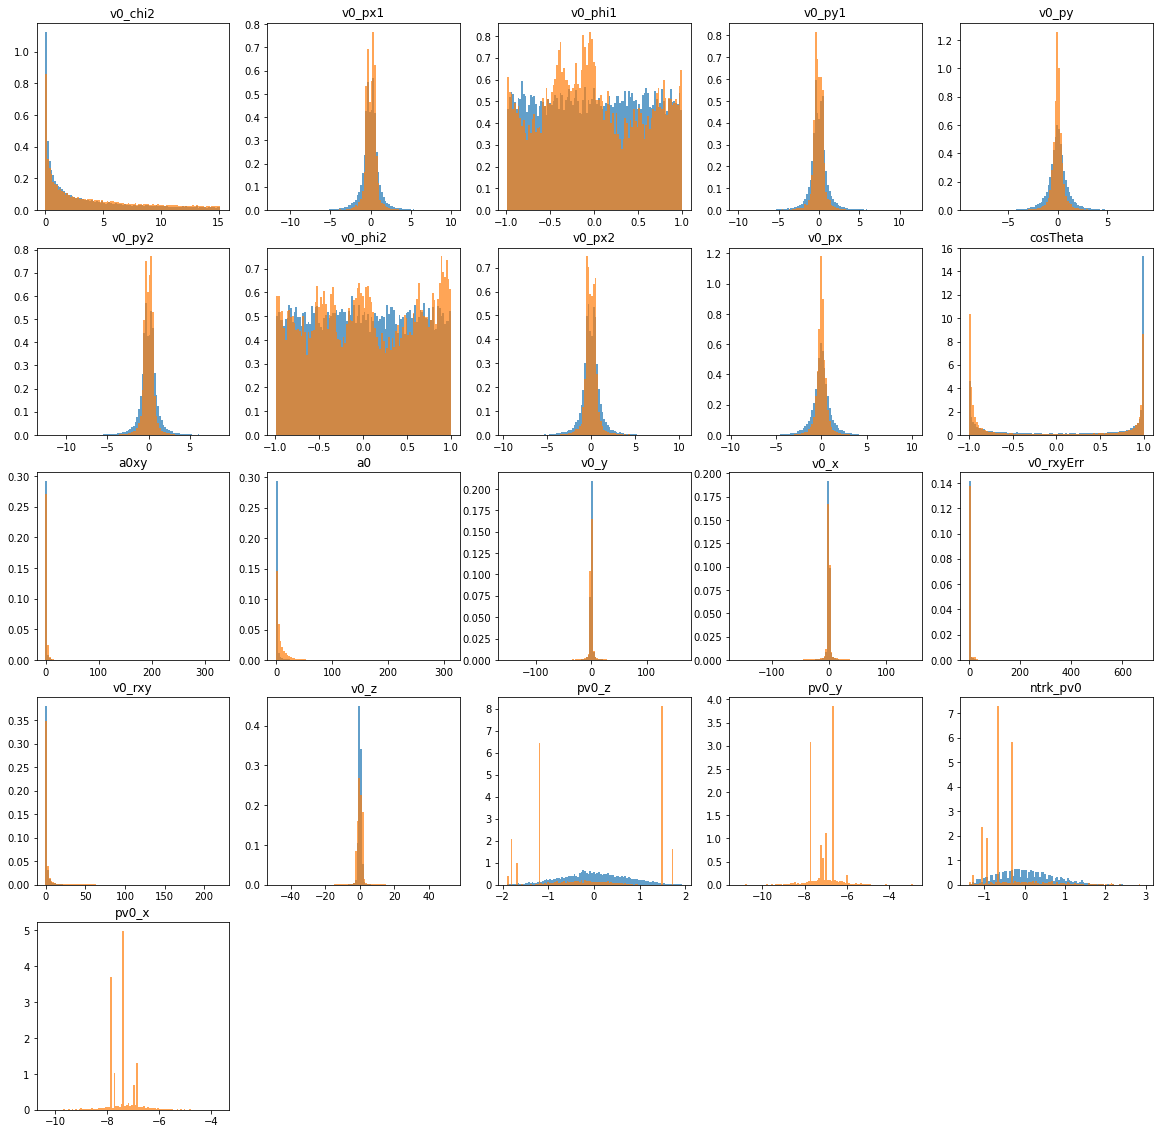

In [9]:
s, sarray=draw_distributions(mc_test[uncorrelated], data_test[uncorrelated], mcweights_test)

Checking out the non_scaled population

v0_chi2
KS over  v0_chi2  =  0.07568583447571142
v0_px1
KS over  v0_px1  =  0.07940476963234075
v0_phi1
KS over  v0_phi1  =  0.015326116788909494
v0_py1
KS over  v0_py1  =  0.09034689104982213
v0_py
KS over  v0_py  =  0.11340782572080485
v0_py2
KS over  v0_py2  =  0.09743031937549684
v0_phi2
KS over  v0_phi2  =  0.029302542233756945
v0_px2
KS over  v0_px2  =  0.09329858582647099
v0_px
KS over  v0_px  =  0.11021115717415286
cosTheta
KS over  cosTheta  =  0.17735876151180235
a0xy
KS over  a0xy  =  0.22217289439659782
a0
KS over  a0  =  0.4471401466030466
v0_y
KS over  v0_y  =  0.09339358676977993
v0_x
KS over  v0_x  =  0.0904590312150716
v0_rxyErr
KS over  v0_rxyErr  =  0.1048961202260085
v0_rxy
KS over  v0_rxy  =  0.1724428345445333
v0_z
KS over  v0_z  =  0.13946854503123768
pv0_z
KS over  pv0_z  =  0.3142856135896774
pv0_y
KS over  pv0_y  =  0.9998015784289827
ntrk_pv0
KS over  ntrk_pv0  =  0.41707931201889437
pv0_x
KS over  pv0_x  =  0.9998375335684987


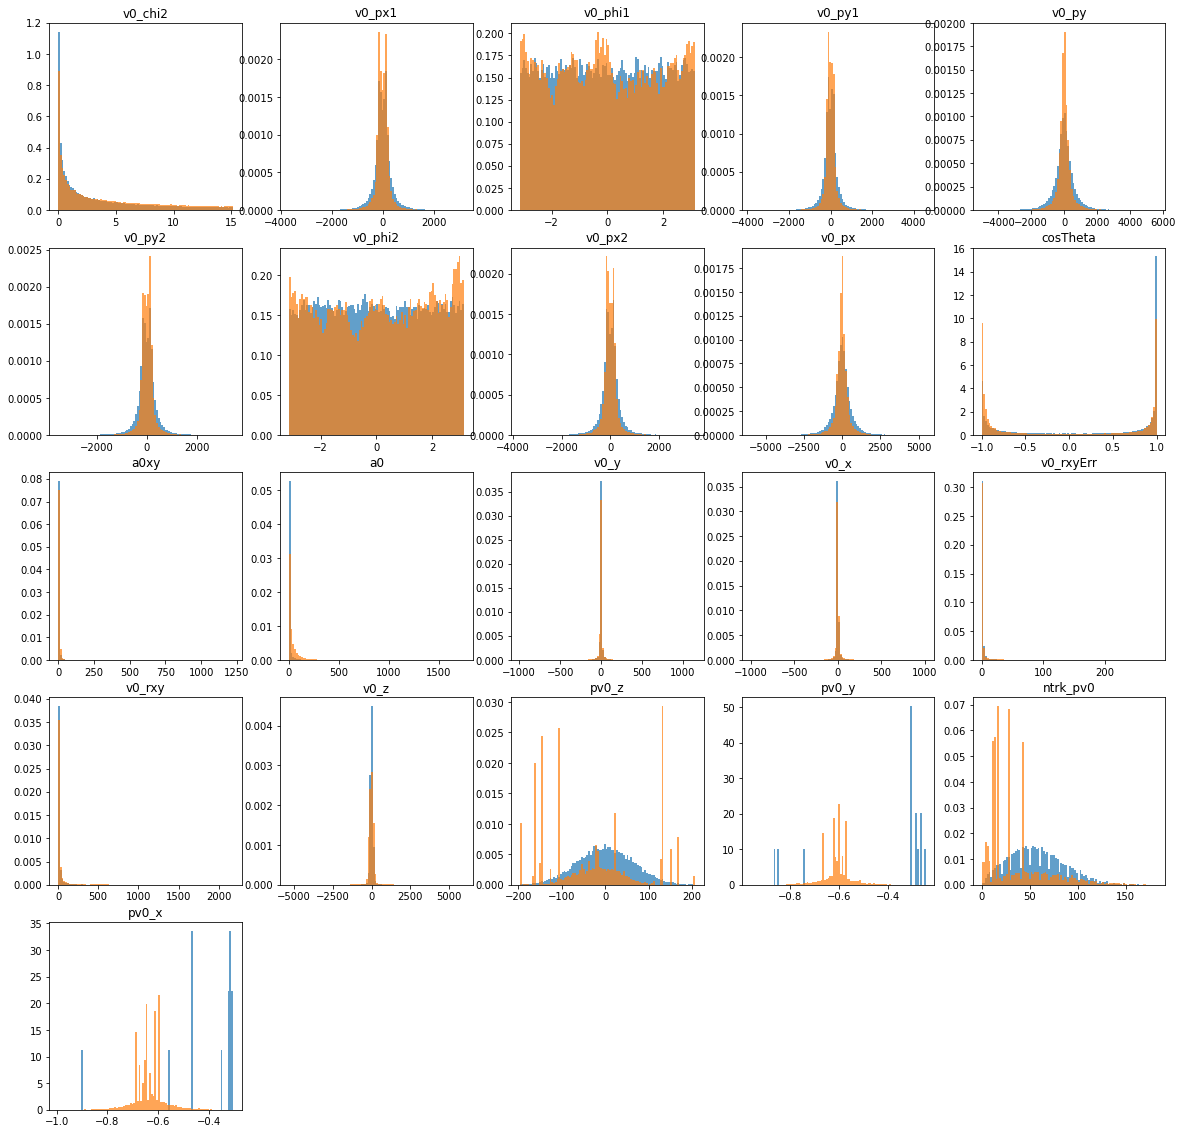

In [10]:
sorig, sorigarray=draw_distributions(mc[uncorrelated], data[uncorrelated], np.ones(len(mc)))

In [11]:
sorig/s

0.8876133532295211

In [12]:
sorig

0.23251190477055225

### We gain a bit with the new scaled and centereed distributions, about 3%

In [13]:
paramsure=['v0_ks_mass','v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2', 'v0_phi2', 'v0_px2', 'v0_px', 'cosTheta', 'a0xy', 'v0_x', 'v0_rxyErr', 'v0_z' ]
extra=[ 'a0xy', 'a0,' 'v0_x', 'v0_rxyErr', 'v0_z', 'pv0_z']
extra=[ 'a0xy', 'v0_rxyErr']

In [14]:
features=paramsure
slist=[]
#trying to add ks mass to non scaled
mc_test, mc_train, data_test, data_train, truetest, truetrain=scale_split(mc, data, 0.7, features, ['v0_chi2', 'cosTheta', 'v0_ks_mass'])
reweighter = GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=5, min_samples_leaf=1000)
reweighter.fit(mc_train[features], data_train[features])

GBReweighter(gb_args={}, learning_rate=0.1, max_depth=5, min_samples_leaf=1000,
             n_estimators=50)

v0_ks_mass
v0_chi2
v0_px1
v0_phi1
v0_py1
v0_py
v0_py2
v0_phi2
v0_px2
v0_px
cosTheta
a0xy
v0_x
v0_rxyErr
v0_z


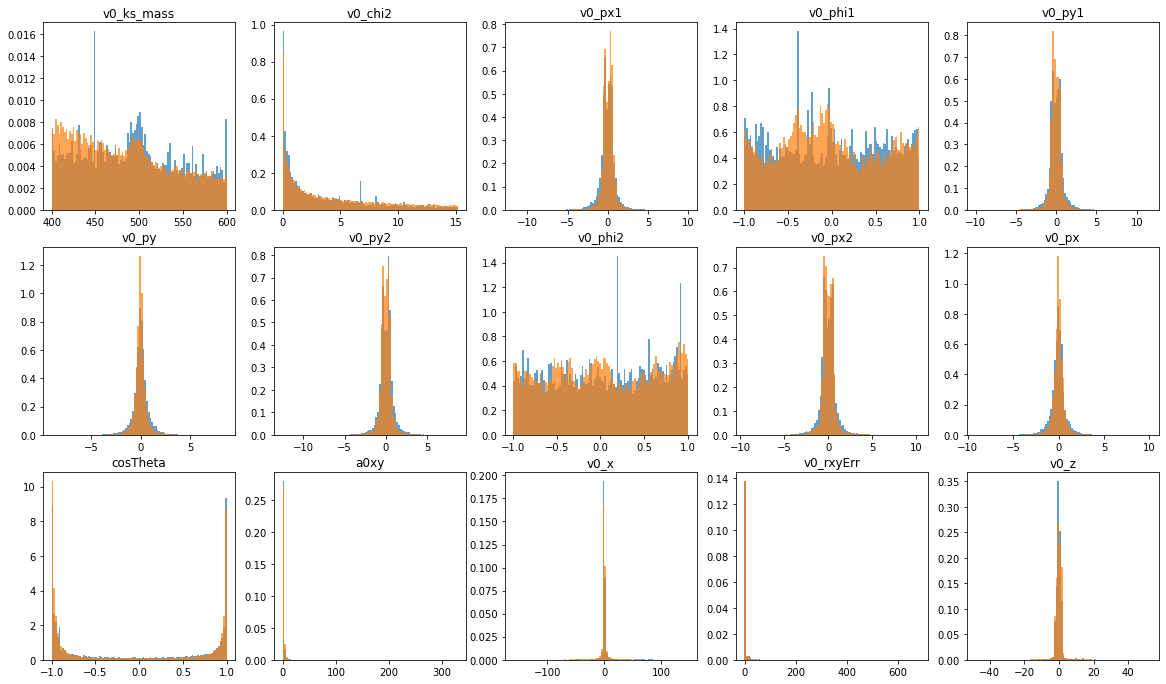

In [15]:
gb_weights_test = reweighter.predict_weights(mc_test[features])
# validate reweighting rule on the test part comparing 1d projections
s, _ =draw_distributions(mc_test[features], data_test[features], gb_weights_test, verbose=0)
slist.append(s)

In [16]:
s, sorig/s

(0.07601430531782032, 3.058791418252212)

## 6 times better! Watch out for disturbance in mass though

In [17]:
#NAMES: mc_test, mc_train, data_test, data_train, truetest, truetrain
params=features[1:]
import xgboost
train_weights = reweighter.predict_weights(mc_train[paramsure])
test_weights = reweighter.predict_weights(mc_test[paramsure])
eval_s = [(mc_train[params], truetrain), (mc_test[params], truetest)]
eval_weights=[train_weights, test_weights]
model = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 1000)
model.fit(mc_train[params], truetrain, sample_weight=train_weights, verbose=True,eval_set=eval_s, sample_weight_eval_set=eval_weights,
          early_stopping_rounds=30,eval_metric ="auc")

[0]	validation_0-auc:0.96079	validation_1-auc:0.954922
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.961328	validation_1-auc:0.955372
[2]	validation_0-auc:0.961318	validation_1-auc:0.95536
[3]	validation_0-auc:0.966961	validation_1-auc:0.961017
[4]	validation_0-auc:0.966947	validation_1-auc:0.961028
[5]	validation_0-auc:0.967085	validation_1-auc:0.961157
[6]	validation_0-auc:0.967306	validation_1-auc:0.961412
[7]	validation_0-auc:0.967263	validation_1-auc:0.961367
[8]	validation_0-auc:0.967427	validation_1-auc:0.961568
[9]	validation_0-auc:0.96743	validation_1-auc:0.961559
[10]	validation_0-auc:0.967458	validation_1-auc:0.961559
[11]	validation_0-auc:0.967463	validation_1-auc:0.961601
[12]	validation_0-auc:0.967553	validation_1-auc:0.961635
[13]	validation_0-auc:0.967554	validation_1-auc:0.961641
[14]	validation_0-auc:0.967568	validation_1-auc:0.961652
[

[142]	validation_0-auc:0.984416	validation_1-auc:0.980567
[143]	validation_0-auc:0.984406	validation_1-auc:0.980574
[144]	validation_0-auc:0.984413	validation_1-auc:0.980578
[145]	validation_0-auc:0.984422	validation_1-auc:0.980584
[146]	validation_0-auc:0.984426	validation_1-auc:0.980592
[147]	validation_0-auc:0.984436	validation_1-auc:0.980598
[148]	validation_0-auc:0.98446	validation_1-auc:0.980618
[149]	validation_0-auc:0.984472	validation_1-auc:0.980624
[150]	validation_0-auc:0.984465	validation_1-auc:0.98063
[151]	validation_0-auc:0.984472	validation_1-auc:0.980637
[152]	validation_0-auc:0.984472	validation_1-auc:0.980646
[153]	validation_0-auc:0.984625	validation_1-auc:0.981059
[154]	validation_0-auc:0.984649	validation_1-auc:0.981075
[155]	validation_0-auc:0.984652	validation_1-auc:0.98108
[156]	validation_0-auc:0.984652	validation_1-auc:0.981082
[157]	validation_0-auc:0.984655	validation_1-auc:0.981088
[158]	validation_0-auc:0.984695	validation_1-auc:0.98115
[159]	validation_0

[284]	validation_0-auc:0.988034	validation_1-auc:0.984419
[285]	validation_0-auc:0.988048	validation_1-auc:0.984341
[286]	validation_0-auc:0.988047	validation_1-auc:0.984331
[287]	validation_0-auc:0.988072	validation_1-auc:0.984331
Stopping. Best iteration:
[257]	validation_0-auc:0.987659	validation_1-auc:0.9851



XGBClassifier(learning_rate=0.02, n_estimators=1000)

In [18]:
# import shap

# # load JS visualization code to notebook
# shap.initjs()

# # explain the model's predictions using SHAP
# # (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(mc_train[params])

# # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.summary_plot(shap_values, mc_train[params])

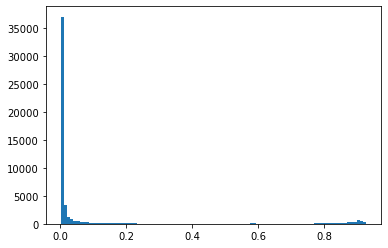

In [19]:
pxg=model.predict_proba(data_train[params])[:,1]
plt.hist(pxg, bins=100);
# plt.yscale('log')

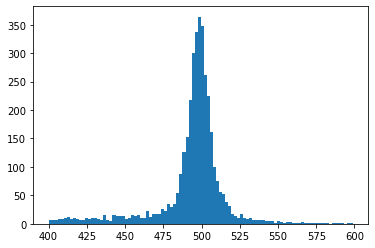

In [20]:
true=pxg>0.7
plt.hist(data_train.v0_ks_mass[true], bins=100);

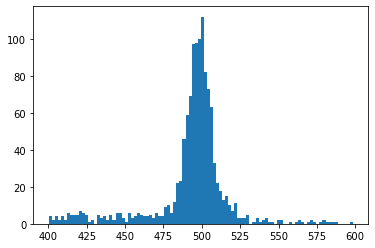

In [21]:
#just for fun
pxgt=model.predict_proba(data_test[params])[:,1]
truetest=pxgt>0.7
plt.hist(data_test.v0_ks_mass[truetest], bins=100);

In [22]:
eval_s = [(data_train[params], true), (data_test[params], truetest)]
# tsts.append(X_train)
modeldata = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modeldata.fit(data_train[params], true,verbose=True,eval_set=eval_s,early_stopping_rounds=30,eval_metric ="auc")

[0]	validation_0-auc:0.997373	validation_1-auc:0.995561
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.997364	validation_1-auc:0.995524
[2]	validation_0-auc:0.997361	validation_1-auc:0.995525
[3]	validation_0-auc:0.997389	validation_1-auc:0.995552
[4]	validation_0-auc:0.997389	validation_1-auc:0.995557
[5]	validation_0-auc:0.99745	validation_1-auc:0.995593
[6]	validation_0-auc:0.997458	validation_1-auc:0.995594
[7]	validation_0-auc:0.998012	validation_1-auc:0.99603
[8]	validation_0-auc:0.998137	validation_1-auc:0.996267
[9]	validation_0-auc:0.998141	validation_1-auc:0.99627
[10]	validation_0-auc:0.998167	validation_1-auc:0.99629
[11]	validation_0-auc:0.998567	validation_1-auc:0.99668
[12]	validation_0-auc:0.998568	validation_1-auc:0.996682
[13]	validation_0-auc:0.998584	validation_1-auc:0.996706
[14]	validation_0-auc:0.998608	validation_1-auc:0.996709
[15

[142]	validation_0-auc:0.999865	validation_1-auc:0.999009
[143]	validation_0-auc:0.999866	validation_1-auc:0.999012
[144]	validation_0-auc:0.999868	validation_1-auc:0.999014
[145]	validation_0-auc:0.999868	validation_1-auc:0.999014
[146]	validation_0-auc:0.999871	validation_1-auc:0.999016
[147]	validation_0-auc:0.999872	validation_1-auc:0.999017
[148]	validation_0-auc:0.999873	validation_1-auc:0.999017
[149]	validation_0-auc:0.999878	validation_1-auc:0.99902
[150]	validation_0-auc:0.999878	validation_1-auc:0.999021
[151]	validation_0-auc:0.999879	validation_1-auc:0.999024
[152]	validation_0-auc:0.999881	validation_1-auc:0.999026
[153]	validation_0-auc:0.999883	validation_1-auc:0.999027
[154]	validation_0-auc:0.999883	validation_1-auc:0.999026
[155]	validation_0-auc:0.999885	validation_1-auc:0.999029
[156]	validation_0-auc:0.999887	validation_1-auc:0.999031
[157]	validation_0-auc:0.99989	validation_1-auc:0.999034
[158]	validation_0-auc:0.99989	validation_1-auc:0.999036
[159]	validation_

XGBClassifier(learning_rate=0.02, n_estimators=200)

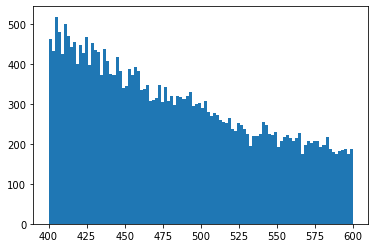

In [23]:
p_final=modeldata.predict_proba(data_test[params])[:,0]
true_final=p_final>0.75
plt.hist(data_test.v0_ks_mass[true_final], bins=100);

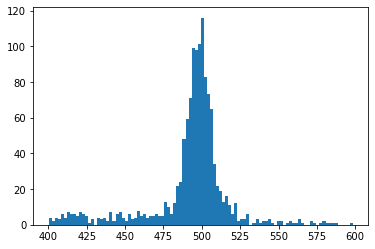

In [24]:
plt.hist(data_test.v0_ks_mass[~true_final], bins=100);

Completed fit with Chi2: 112.7, p-val: 0.061 and the total amount of signal 1147 +/- 96, background: 30245
Completed fit with Chi2: 112.5, p-val: 0.063 and the total amount of signal 890 +/- 83, background: 30188
Completed fit with Chi2: 115.7, p-val: 0.041 and the total amount of signal 641 +/- 55, background: 30124
Completed fit with Chi2: 112.5, p-val: 0.063 and the total amount of signal 397 +/- 118, background: 30053
Completed fit with Chi2: 110.6, p-val: 0.079 and the total amount of signal 235 +/- 89, background: 29901
Completed fit with Chi2: 107.9, p-val: 0.109 and the total amount of signal 185 +/- 84, background: 29637
Completed fit with Chi2: 108.8, p-val: 0.098 and the total amount of signal 150 +/- 87, background: 29358
Completed fit with Chi2: 112.0, p-val: 0.067 and the total amount of signal 143 +/- 77, background: 29052
Completed fit with Chi2: 111.9, p-val: 0.067 and the total amount of signal 138 +/- 70, background: 28742
Completed fit with Chi2: 111.2, p-val: 0.073

Completed fit with Chi2: 89.3, p-val: 0.531 and the total amount of signal 61 +/- 32, background: 6533
Completed fit with Chi2: 88.7, p-val: 0.549 and the total amount of signal 60 +/- 26, background: 6220
Completed fit with Chi2: 86.9, p-val: 0.603 and the total amount of signal 58 +/- 26, background: 5908
Completed fit with Chi2: 91.6, p-val: 0.461 and the total amount of signal 54 +/- 7, background: 5598
Completed fit with Chi2: 102.1, p-val: 0.200 and the total amount of signal 47 +/- 5, background: 5291
Completed fit with Chi2: 110.0, p-val: 0.086 and the total amount of signal 39 +/- 23, background: 4984
Completed fit with Chi2: 118.6, p-val: 0.027 and the total amount of signal 39 +/- 16, background: 4671
Completed fit with Chi2: 120.4, p-val: 0.021 and the total amount of signal 46 +/- 23, background: 4350
Completed fit with Chi2: 124.1, p-val: 0.012 and the total amount of signal 35 +/- 23, background: 4047
Completed fit with Chi2: 127.1, p-val: 0.007 and the total amount of s

(-0.06571123172599384,
 array([    0,   313,   627,   941,  1255,  1569,  1883,  2197,  2511,
         2825,  3139,  3453,  3766,  4080,  4394,  4708,  5022,  5336,
         5650,  5964,  6278,  6592,  6906,  7219,  7533,  7847,  8161,
         8475,  8789,  9103,  9417,  9731, 10045, 10359, 10672, 10986,
        11300, 11614, 11928, 12242, 12556, 12870, 13184, 13498, 13812,
        14125, 14439, 14753, 15067, 15381, 15695, 16009, 16323, 16637,
        16951, 17265, 17578, 17892, 18206, 18520, 18834, 19148, 19462,
        19776, 20090, 20404, 20718, 21031, 21345, 21659, 21973, 22287,
        22601, 22915, 23229, 23543, 23857, 24171, 24484, 24798, 25112,
        25426, 25740, 26054, 26368, 26682, 26996, 27310, 27624, 27937,
        28251, 28565, 28879, 29193, 29507, 29821, 30135, 30449, 30763,
        31077]))

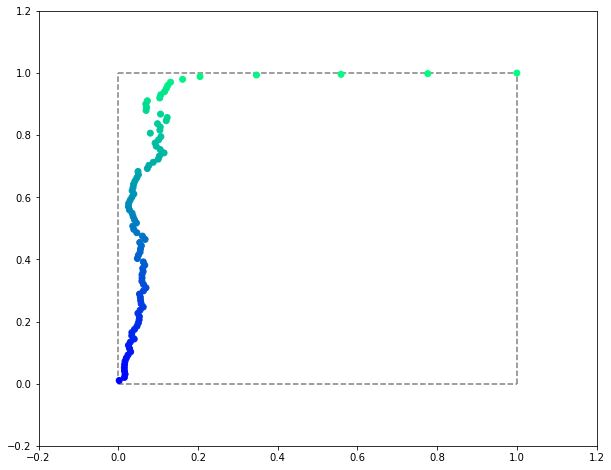

In [25]:
fig1, ax1=plt.subplots(figsize=(10,8))
hm.roc_curve_data(data_test.v0_ks_mass, p_final, Npoints = 100, bins = 100, range = (400, 600), ax_roc = ax1 ,\
             verbose = True, plimit = 0.01)

In [26]:
mc_test, mc_train, data_test, data_train, truetest, truetrain=scale_split(mc, data, 0.7, np.hstack((uncorrelated, ['v0_ks_mass'])), ['v0_chi2','v0_ks_mass', 'cosTheta'])
eval_s = [(mc_train[uncorrelated], truetrain), (mc_test[uncorrelated], truetest)]
model = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
model.fit(mc_train[uncorrelated], truetrain, verbose=True,eval_set=eval_s,
          early_stopping_rounds=30,eval_metric ="auc")

[0]	validation_0-auc:0.973481	validation_1-auc:0.972301
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.973741	validation_1-auc:0.972548
[2]	validation_0-auc:0.974002	validation_1-auc:0.972687
[3]	validation_0-auc:0.974182	validation_1-auc:0.972848
[4]	validation_0-auc:0.974493	validation_1-auc:0.973293
[5]	validation_0-auc:0.975245	validation_1-auc:0.97372
[6]	validation_0-auc:0.975384	validation_1-auc:0.973822
[7]	validation_0-auc:0.975441	validation_1-auc:0.97387
[8]	validation_0-auc:0.977256	validation_1-auc:0.975529
[9]	validation_0-auc:0.978871	validation_1-auc:0.977196
[10]	validation_0-auc:0.97887	validation_1-auc:0.977228
[11]	validation_0-auc:0.978904	validation_1-auc:0.977255
[12]	validation_0-auc:0.978916	validation_1-auc:0.977267
[13]	validation_0-auc:0.978965	validation_1-auc:0.977322
[14]	validation_0-auc:0.979095	validation_1-auc:0.977421
[

[141]	validation_0-auc:0.984985	validation_1-auc:0.982821
[142]	validation_0-auc:0.985044	validation_1-auc:0.982879
[143]	validation_0-auc:0.985054	validation_1-auc:0.98289
[144]	validation_0-auc:0.98517	validation_1-auc:0.982922
[145]	validation_0-auc:0.985183	validation_1-auc:0.982933
[146]	validation_0-auc:0.985204	validation_1-auc:0.982947
[147]	validation_0-auc:0.985215	validation_1-auc:0.982961
[148]	validation_0-auc:0.985228	validation_1-auc:0.982963
[149]	validation_0-auc:0.985313	validation_1-auc:0.983038
[150]	validation_0-auc:0.985326	validation_1-auc:0.983045
[151]	validation_0-auc:0.985338	validation_1-auc:0.983062
[152]	validation_0-auc:0.985348	validation_1-auc:0.983072
[153]	validation_0-auc:0.985356	validation_1-auc:0.983076
[154]	validation_0-auc:0.985358	validation_1-auc:0.983069
[155]	validation_0-auc:0.985367	validation_1-auc:0.983078
[156]	validation_0-auc:0.985397	validation_1-auc:0.983079
[157]	validation_0-auc:0.985413	validation_1-auc:0.983093
[158]	validation

XGBClassifier(learning_rate=0.02, n_estimators=200)

[0]	validation_0-auc:0.998066	validation_1-auc:0.998821
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.998066	validation_1-auc:0.998821
[2]	validation_0-auc:0.998066	validation_1-auc:0.998821
[3]	validation_0-auc:0.998442	validation_1-auc:0.999047
[4]	validation_0-auc:0.998459	validation_1-auc:0.999063
[5]	validation_0-auc:0.998537	validation_1-auc:0.99908
[6]	validation_0-auc:0.998533	validation_1-auc:0.999074
[7]	validation_0-auc:0.998533	validation_1-auc:0.999072
[8]	validation_0-auc:0.998792	validation_1-auc:0.999129
[9]	validation_0-auc:0.998838	validation_1-auc:0.999184
[10]	validation_0-auc:0.998847	validation_1-auc:0.99917
[11]	validation_0-auc:0.998896	validation_1-auc:0.999196
[12]	validation_0-auc:0.998902	validation_1-auc:0.999196
[13]	validation_0-auc:0.998896	validation_1-auc:0.999197
[14]	validation_0-auc:0.998907	validation_1-auc:0.9992
[1

[141]	validation_0-auc:0.999906	validation_1-auc:0.999929
[142]	validation_0-auc:0.999907	validation_1-auc:0.99993
[143]	validation_0-auc:0.999907	validation_1-auc:0.999929
[144]	validation_0-auc:0.999909	validation_1-auc:0.999932
[145]	validation_0-auc:0.99991	validation_1-auc:0.999932
[146]	validation_0-auc:0.999912	validation_1-auc:0.999933
[147]	validation_0-auc:0.999912	validation_1-auc:0.999933
[148]	validation_0-auc:0.999914	validation_1-auc:0.999935
[149]	validation_0-auc:0.999914	validation_1-auc:0.999935
[150]	validation_0-auc:0.999915	validation_1-auc:0.999936
[151]	validation_0-auc:0.999919	validation_1-auc:0.999938
[152]	validation_0-auc:0.999919	validation_1-auc:0.999938
[153]	validation_0-auc:0.99992	validation_1-auc:0.999939
[154]	validation_0-auc:0.999921	validation_1-auc:0.999941
[155]	validation_0-auc:0.999921	validation_1-auc:0.999942
[156]	validation_0-auc:0.999922	validation_1-auc:0.999942
[157]	validation_0-auc:0.999923	validation_1-auc:0.999943
[158]	validation_

XGBClassifier(learning_rate=0.02, n_estimators=200)

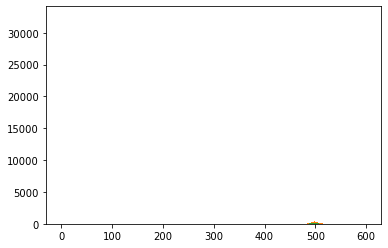

In [27]:
pxg=model.predict_proba(data_train[uncorrelated])[:,1]
plt.hist(pxg, bins=100);
# plt.yscale('log')
true=pxg>0.7
plt.hist(data_train.v0_ks_mass[true], bins=100);
#just for fun
#just for fun
pxgt=model.predict_proba(data_test[uncorrelated])[:,1]
true_test=pxgt>0.7
plt.hist(data_test.v0_ks_mass[true_test], bins=100);


eval_s = [(data_train[uncorrelated], true), (data_test[uncorrelated], true_test)]
modeldata = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modeldata.fit(data_train[uncorrelated], true,verbose=True,eval_set=eval_s,early_stopping_rounds=30,eval_metric ="auc")

Completed fit with Chi2: 112.7, p-val: 0.061 and the total amount of signal 1147 +/- 96, background: 30245
Completed fit with Chi2: 112.5, p-val: 0.063 and the total amount of signal 890 +/- 83, background: 30188
Completed fit with Chi2: 115.7, p-val: 0.041 and the total amount of signal 641 +/- 55, background: 30124
Completed fit with Chi2: 112.5, p-val: 0.063 and the total amount of signal 397 +/- 118, background: 30053
Completed fit with Chi2: 110.6, p-val: 0.079 and the total amount of signal 235 +/- 89, background: 29901
Completed fit with Chi2: 107.9, p-val: 0.109 and the total amount of signal 185 +/- 84, background: 29637
Completed fit with Chi2: 108.8, p-val: 0.098 and the total amount of signal 150 +/- 87, background: 29358
Completed fit with Chi2: 112.0, p-val: 0.067 and the total amount of signal 143 +/- 77, background: 29052
Completed fit with Chi2: 111.9, p-val: 0.067 and the total amount of signal 138 +/- 70, background: 28742
Completed fit with Chi2: 111.2, p-val: 0.073

Completed fit with Chi2: 89.3, p-val: 0.531 and the total amount of signal 61 +/- 32, background: 6533
Completed fit with Chi2: 88.7, p-val: 0.549 and the total amount of signal 60 +/- 26, background: 6220
Completed fit with Chi2: 86.9, p-val: 0.603 and the total amount of signal 58 +/- 26, background: 5908
Completed fit with Chi2: 91.6, p-val: 0.461 and the total amount of signal 54 +/- 7, background: 5598
Completed fit with Chi2: 102.1, p-val: 0.200 and the total amount of signal 47 +/- 5, background: 5291
Completed fit with Chi2: 110.0, p-val: 0.086 and the total amount of signal 39 +/- 23, background: 4984
Completed fit with Chi2: 118.6, p-val: 0.027 and the total amount of signal 39 +/- 16, background: 4671
Completed fit with Chi2: 120.4, p-val: 0.021 and the total amount of signal 46 +/- 23, background: 4350
Completed fit with Chi2: 124.1, p-val: 0.012 and the total amount of signal 35 +/- 23, background: 4047
Completed fit with Chi2: 127.1, p-val: 0.007 and the total amount of s

(-0.06571123172599384,
 array([    0,   313,   627,   941,  1255,  1569,  1883,  2197,  2511,
         2825,  3139,  3453,  3766,  4080,  4394,  4708,  5022,  5336,
         5650,  5964,  6278,  6592,  6906,  7219,  7533,  7847,  8161,
         8475,  8789,  9103,  9417,  9731, 10045, 10359, 10672, 10986,
        11300, 11614, 11928, 12242, 12556, 12870, 13184, 13498, 13812,
        14125, 14439, 14753, 15067, 15381, 15695, 16009, 16323, 16637,
        16951, 17265, 17578, 17892, 18206, 18520, 18834, 19148, 19462,
        19776, 20090, 20404, 20718, 21031, 21345, 21659, 21973, 22287,
        22601, 22915, 23229, 23543, 23857, 24171, 24484, 24798, 25112,
        25426, 25740, 26054, 26368, 26682, 26996, 27310, 27624, 27937,
        28251, 28565, 28879, 29193, 29507, 29821, 30135, 30449, 30763,
        31077]))

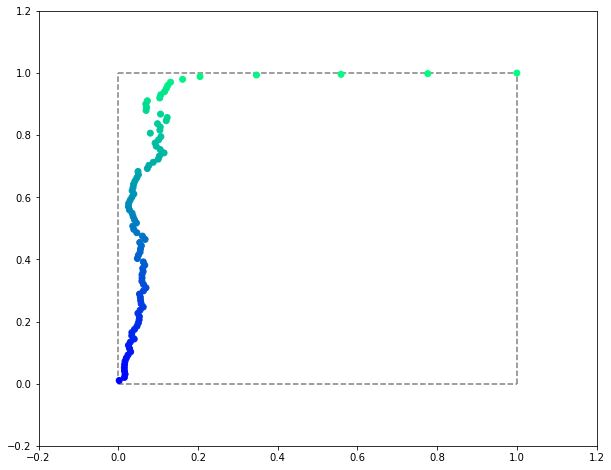

In [28]:
fig1, ax1=plt.subplots(figsize=(10,8))
hm.roc_curve_data(data_test.v0_ks_mass, p_final, Npoints = 100, bins = 100, range = (400, 600), ax_roc = ax1 ,\
             verbose = True, plimit = 0.01)

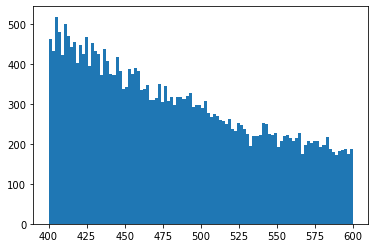

In [29]:
p_final=modeldata.predict_proba(data_test[uncorrelated])[:,0]
true_final=p_final>0.8
plt.hist(data_test.v0_ks_mass[true_final], bins=100);

# Testing straight training in MC

In [30]:
train_weights = reweighter.predict_weights(mc_train[paramsure])
test_weights = reweighter.predict_weights(mc_test[paramsure])
eval_s = [(mc_train[params], truetrain), (mc_test[params], truetest)]
eval_weights=[train_weights, test_weights]
modelw = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modelw.fit(mc_train[params], truetrain, sample_weight=train_weights, verbose=True,eval_set=eval_s, sample_weight_eval_set=eval_weights,
          early_stopping_rounds=30,eval_metric ="auc")

[0]	validation_0-auc:0.96079	validation_1-auc:0.954922
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.961328	validation_1-auc:0.955372
[2]	validation_0-auc:0.961318	validation_1-auc:0.95536
[3]	validation_0-auc:0.966961	validation_1-auc:0.961017
[4]	validation_0-auc:0.966947	validation_1-auc:0.961028
[5]	validation_0-auc:0.967085	validation_1-auc:0.961157
[6]	validation_0-auc:0.967306	validation_1-auc:0.961412
[7]	validation_0-auc:0.967263	validation_1-auc:0.961367
[8]	validation_0-auc:0.967427	validation_1-auc:0.961568
[9]	validation_0-auc:0.96743	validation_1-auc:0.961559
[10]	validation_0-auc:0.967458	validation_1-auc:0.961559
[11]	validation_0-auc:0.967463	validation_1-auc:0.961601
[12]	validation_0-auc:0.967553	validation_1-auc:0.961635
[13]	validation_0-auc:0.967554	validation_1-auc:0.961641
[14]	validation_0-auc:0.967568	validation_1-auc:0.961652
[

[142]	validation_0-auc:0.984416	validation_1-auc:0.980567
[143]	validation_0-auc:0.984406	validation_1-auc:0.980574
[144]	validation_0-auc:0.984413	validation_1-auc:0.980578
[145]	validation_0-auc:0.984422	validation_1-auc:0.980584
[146]	validation_0-auc:0.984426	validation_1-auc:0.980592
[147]	validation_0-auc:0.984436	validation_1-auc:0.980598
[148]	validation_0-auc:0.98446	validation_1-auc:0.980618
[149]	validation_0-auc:0.984472	validation_1-auc:0.980624
[150]	validation_0-auc:0.984465	validation_1-auc:0.98063
[151]	validation_0-auc:0.984472	validation_1-auc:0.980637
[152]	validation_0-auc:0.984472	validation_1-auc:0.980646
[153]	validation_0-auc:0.984625	validation_1-auc:0.981059
[154]	validation_0-auc:0.984649	validation_1-auc:0.981075
[155]	validation_0-auc:0.984652	validation_1-auc:0.98108
[156]	validation_0-auc:0.984652	validation_1-auc:0.981082
[157]	validation_0-auc:0.984655	validation_1-auc:0.981088
[158]	validation_0-auc:0.984695	validation_1-auc:0.98115
[159]	validation_0

XGBClassifier(learning_rate=0.02, n_estimators=200)

In [31]:
pxgw=modelw.predict_proba(data_train[params])[:,0]

No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!


-0.022130537070206496

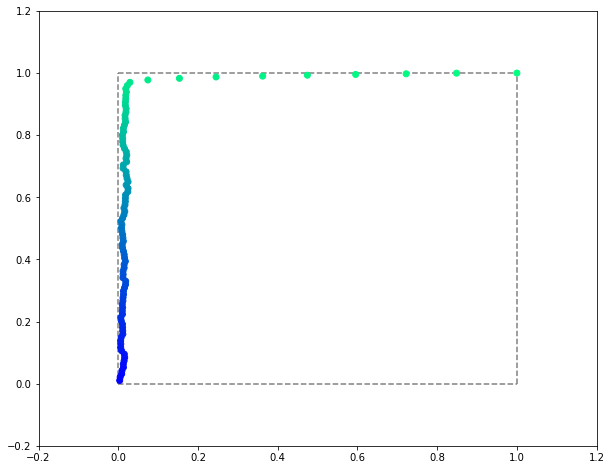

In [32]:
fig1, ax1=plt.subplots(figsize=(10,8))
a, b = hm.roc_curve_data(data_train.v0_ks_mass, pxgw, Npoints = 100, bins = 100, range = (400, 600), ax_roc = ax1 ,\
             verbose = False, plimit = 0.01)
a

In [33]:
mc_test, mc_train, data_test, data_train, truetest, truetrain=scale_split(mc, data, 0.7, np.hstack((uncorrelated, ['v0_ks_mass'])), ['v0_chi2','v0_ks_mass', 'cosTheta'])
eval_s = [(mc_train[uncorrelated], truetrain), (mc_test[uncorrelated], truetest)]
modelnw = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modelnw.fit(mc_train[uncorrelated], truetrain, eval_set=eval_s, verbose=True, early_stopping_rounds=30,eval_metric ="auc")

[0]	validation_0-auc:0.973481	validation_1-auc:0.972301
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.973741	validation_1-auc:0.972548
[2]	validation_0-auc:0.974002	validation_1-auc:0.972687
[3]	validation_0-auc:0.974182	validation_1-auc:0.972848
[4]	validation_0-auc:0.974493	validation_1-auc:0.973293
[5]	validation_0-auc:0.975245	validation_1-auc:0.97372
[6]	validation_0-auc:0.975384	validation_1-auc:0.973822
[7]	validation_0-auc:0.975441	validation_1-auc:0.97387
[8]	validation_0-auc:0.977256	validation_1-auc:0.975529
[9]	validation_0-auc:0.978871	validation_1-auc:0.977196
[10]	validation_0-auc:0.97887	validation_1-auc:0.977228
[11]	validation_0-auc:0.978904	validation_1-auc:0.977255
[12]	validation_0-auc:0.978916	validation_1-auc:0.977267
[13]	validation_0-auc:0.978965	validation_1-auc:0.977322
[14]	validation_0-auc:0.979095	validation_1-auc:0.977421
[

[141]	validation_0-auc:0.984985	validation_1-auc:0.982821
[142]	validation_0-auc:0.985044	validation_1-auc:0.982879
[143]	validation_0-auc:0.985054	validation_1-auc:0.98289
[144]	validation_0-auc:0.98517	validation_1-auc:0.982922
[145]	validation_0-auc:0.985183	validation_1-auc:0.982933
[146]	validation_0-auc:0.985204	validation_1-auc:0.982947
[147]	validation_0-auc:0.985215	validation_1-auc:0.982961
[148]	validation_0-auc:0.985228	validation_1-auc:0.982963
[149]	validation_0-auc:0.985313	validation_1-auc:0.983038
[150]	validation_0-auc:0.985326	validation_1-auc:0.983045
[151]	validation_0-auc:0.985338	validation_1-auc:0.983062
[152]	validation_0-auc:0.985348	validation_1-auc:0.983072
[153]	validation_0-auc:0.985356	validation_1-auc:0.983076
[154]	validation_0-auc:0.985358	validation_1-auc:0.983069
[155]	validation_0-auc:0.985367	validation_1-auc:0.983078
[156]	validation_0-auc:0.985397	validation_1-auc:0.983079
[157]	validation_0-auc:0.985413	validation_1-auc:0.983093
[158]	validation

XGBClassifier(learning_rate=0.02, n_estimators=200)

In [34]:
pxgnw=modelnw.predict_proba(data_train[uncorrelated])[:,0]

No valid minimum found!


-0.017188274690043404

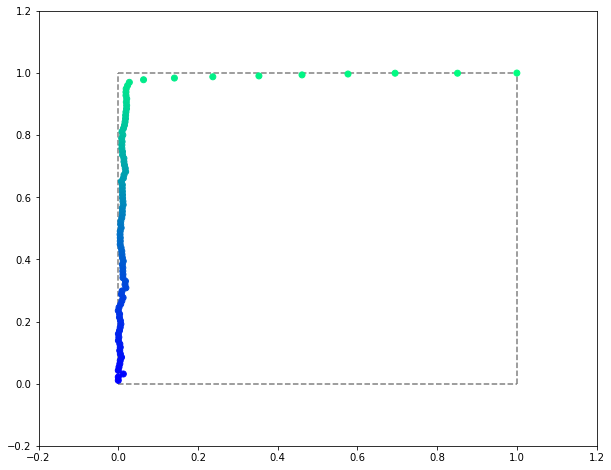

In [35]:
fig1, ax1=plt.subplots(figsize=(10,8))
a,b=hm.roc_curve_data(data_train.v0_ks_mass, pxgnw, Npoints = 100, bins = 100, range = (400, 600), ax_roc = ax1 ,\
             verbose = False, plimit = 0.9)
a

In [36]:
ax1.set(xlabel='FPR', ylabel='TPR', xlim=(-0.05,1.05), ylim=(-0.05,1.05), title=f'Estimated ROC curve, AUC $\approx$ {1+a}')
plt.savefig('roccurvenoreweigh.pdf')

<Figure size 432x288 with 0 Axes>

In [37]:
uncorrelated=params
mc_test, mc_train, data_test, data_train, truetest, truetrain=scale_split(mc, data, 0.7, np.hstack((uncorrelated, ['v0_ks_mass'])), ['v0_chi2','v0_ks_mass', 'cosTheta'])
eval_s = [(pd.concat((data_train[uncorrelated], mc_train[uncorrelated])), np.hstack((np.ones(len(data_train)), np.zeros(len(mc_train))))), 
          (pd.concat((data_test[uncorrelated], mc_test[uncorrelated])),  np.hstack((np.ones(len(data_test)), np.zeros(len(mc_test)))))]
modelnw = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modelnw.fit(pd.concat((data_train[uncorrelated], mc_train[uncorrelated])), np.hstack((np.ones(len(data_train)), np.zeros(len(mc_train)))),
            eval_set=eval_s, verbose=True, early_stopping_rounds=30,eval_metric ="auc")

[0]	validation_0-auc:0.653519	validation_1-auc:0.710782
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.655089	validation_1-auc:0.71298
[2]	validation_0-auc:0.655389	validation_1-auc:0.713764
[3]	validation_0-auc:0.655426	validation_1-auc:0.713781
[4]	validation_0-auc:0.656189	validation_1-auc:0.714743
[5]	validation_0-auc:0.658965	validation_1-auc:0.717692
[6]	validation_0-auc:0.671418	validation_1-auc:0.73568
[7]	validation_0-auc:0.67172	validation_1-auc:0.736075
[8]	validation_0-auc:0.673038	validation_1-auc:0.737845
[9]	validation_0-auc:0.675235	validation_1-auc:0.741831
[10]	validation_0-auc:0.676867	validation_1-auc:0.743667
[11]	validation_0-auc:0.677361	validation_1-auc:0.744302
[12]	validation_0-auc:0.678145	validation_1-auc:0.74659
[13]	validation_0-auc:0.688797	validation_1-auc:0.758228
[14]	validation_0-auc:0.69386	validation_1-auc:0.764008
[15

[141]	validation_0-auc:0.742574	validation_1-auc:0.81195
[142]	validation_0-auc:0.742686	validation_1-auc:0.812047
[143]	validation_0-auc:0.74281	validation_1-auc:0.812147
[144]	validation_0-auc:0.742956	validation_1-auc:0.812258
[145]	validation_0-auc:0.743199	validation_1-auc:0.812506
[146]	validation_0-auc:0.743414	validation_1-auc:0.81278
[147]	validation_0-auc:0.74345	validation_1-auc:0.812833
[148]	validation_0-auc:0.743706	validation_1-auc:0.813062
[149]	validation_0-auc:0.743751	validation_1-auc:0.813136
[150]	validation_0-auc:0.743832	validation_1-auc:0.813223
[151]	validation_0-auc:0.744031	validation_1-auc:0.81339
[152]	validation_0-auc:0.744146	validation_1-auc:0.813501
[153]	validation_0-auc:0.744269	validation_1-auc:0.813618
[154]	validation_0-auc:0.744396	validation_1-auc:0.813683
[155]	validation_0-auc:0.744581	validation_1-auc:0.813831
[156]	validation_0-auc:0.744815	validation_1-auc:0.814137
[157]	validation_0-auc:0.745053	validation_1-auc:0.814384
[158]	validation_0-

XGBClassifier(learning_rate=0.02, n_estimators=200)

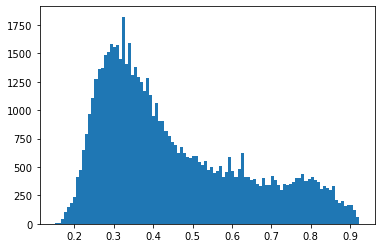

In [38]:
pnw=modelnw.predict_proba(pd.concat((data_test[uncorrelated], mc_test[uncorrelated])))[:,1]
true=pnw>0.7
plt.hist(pnw, bins=100);

In [39]:
train_weights = reweighter.predict_weights(mc_train[paramsure])
test_weights = reweighter.predict_weights(mc_test[paramsure])
eval_weights=[np.hstack((np.ones(len(data_train)), train_weights)), np.hstack((np.ones(len(data_test)), test_weights))]

In [40]:
mc_test, mc_train, data_test, data_train, truetest, truetrain=scale_split(mc, data, 0.7, np.hstack((uncorrelated, ['v0_ks_mass'])), ['v0_chi2','v0_ks_mass', 'cosTheta'])
eval_s = [(pd.concat((data_train[params], mc_train[params])), np.hstack((np.ones(len(data_train)), np.zeros(len(mc_train))))), 
          (pd.concat((data_test[params], mc_test[params])),  np.hstack((np.ones(len(data_test)), np.zeros(len(mc_test)))))]
modelw = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modelw.fit(pd.concat((data_train[params], mc_train[params])), np.hstack((np.ones(len(data_train)), np.zeros(len(mc_train)))), 
            sample_weight=eval_weights[0], eval_set=eval_s, sample_weight_eval_set=eval_weights,
            verbose=True, early_stopping_rounds=30,eval_metric ="auc")

[0]	validation_0-auc:0.574781	validation_1-auc:0.593652
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.599425	validation_1-auc:0.625147
[2]	validation_0-auc:0.606479	validation_1-auc:0.630138
[3]	validation_0-auc:0.60706	validation_1-auc:0.618571
[4]	validation_0-auc:0.607816	validation_1-auc:0.620847
[5]	validation_0-auc:0.607183	validation_1-auc:0.61993
[6]	validation_0-auc:0.610848	validation_1-auc:0.62681
[7]	validation_0-auc:0.610245	validation_1-auc:0.624635
[8]	validation_0-auc:0.617004	validation_1-auc:0.632181
[9]	validation_0-auc:0.618613	validation_1-auc:0.634563
[10]	validation_0-auc:0.62609	validation_1-auc:0.647232
[11]	validation_0-auc:0.625815	validation_1-auc:0.646472
[12]	validation_0-auc:0.630434	validation_1-auc:0.652053
[13]	validation_0-auc:0.631045	validation_1-auc:0.653185
[14]	validation_0-auc:0.631546	validation_1-auc:0.654705
[1

XGBClassifier(learning_rate=0.02, n_estimators=200)

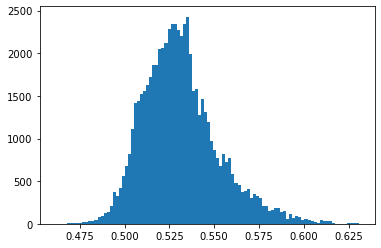

In [41]:
pw=modelw.predict_proba(pd.concat((data_test[params], mc_test[params])))[:,1]
true=pw>0.8
plt.hist(pw, bins=100);

Text(0.5, 1.0, 'ROC curve, AUC: 0.21461543699657193')

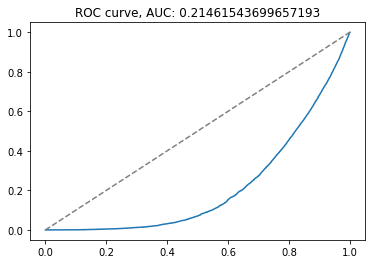

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true=np.hstack((np.ones(len(data_test)), np.zeros(len(mc_test)))),
                                y_score=pw)

fig, ax = plt.subplots()
ax.plot(tpr,fpr)
ax.plot([0,1],[0,1],c='grey',linestyle='--')
ax.set_title(f'ROC curve, AUC: {1-roc_auc_score(y_true=np.hstack((np.ones(len(data_test)), np.zeros(len(mc_test)))),y_score=pw)}')

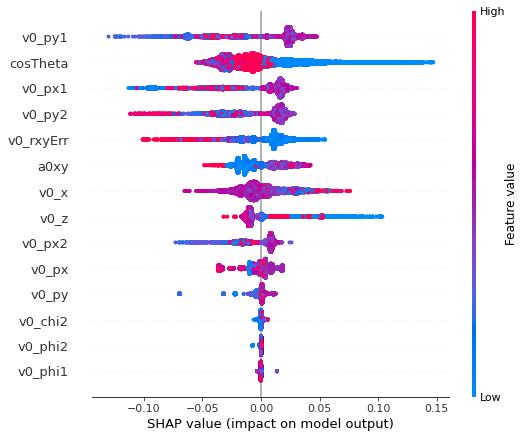

In [43]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(modelw)
shap_values = explainer.shap_values(pd.concat((data_test[params], mc_test[params])))

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.summary_plot(shap_values, pd.concat((data_test[params], mc_test[params])))

Text(0.5, 1.0, 'ROC curve, AUC: 0.1797041276694028')

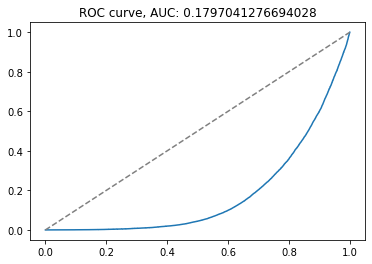

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true=np.hstack((np.ones(len(data_test)), np.zeros(len(mc_test)))),
                                y_score=pnw)

fig, ax = plt.subplots()
ax.plot(tpr,fpr)
ax.plot([0,1],[0,1],c='grey',linestyle='--')
ax.set_title(f'ROC curve, AUC: {1-roc_auc_score(y_true=np.hstack((np.ones(len(data_test)), np.zeros(len(mc_test)))),y_score=pnw)}')

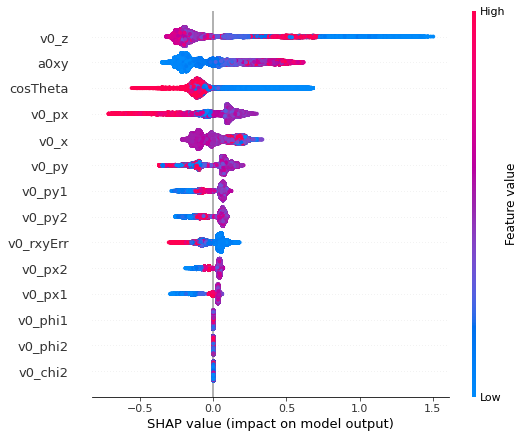

In [45]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(modelnw)
shap_values = explainer.shap_values(pd.concat((data_test[params], mc_test[params])))

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.summary_plot(shap_values, pd.concat((data_test[params], mc_test[params])))

In [46]:
params

['v0_chi2',
 'v0_px1',
 'v0_phi1',
 'v0_py1',
 'v0_py',
 'v0_py2',
 'v0_phi2',
 'v0_px2',
 'v0_px',
 'cosTheta',
 'a0xy',
 'v0_x',
 'v0_rxyErr',
 'v0_z']

# Let's try a different scaling method: MinMaxScaling (with robustness)

v0_ks_mass
KS over  v0_ks_mass  =  0.14701066682772118
v0_chi2
KS over  v0_chi2  =  0.07568583447571142
v0_px1
KS over  v0_px1  =  0.07940476963234075
v0_phi1
KS over  v0_phi1  =  0.015326116788909494
v0_py1
KS over  v0_py1  =  0.09034689104982213
v0_py
KS over  v0_py  =  0.11340782572080485
v0_py2
KS over  v0_py2  =  0.09743031937549684
v0_phi2
KS over  v0_phi2  =  0.029302542233756945
v0_px2
KS over  v0_px2  =  0.09329858582647099
v0_px
KS over  v0_px  =  0.11021115717415286
cosTheta
KS over  cosTheta  =  0.17735876151180235
a0xy
KS over  a0xy  =  0.22217289439659782
a0
KS over  a0  =  0.4471401466030466
v0_y
KS over  v0_y  =  0.09339358676977993
v0_x
KS over  v0_x  =  0.0904590312150716
v0_rxyErr
KS over  v0_rxyErr  =  0.1048961202260085
v0_rxy
KS over  v0_rxy  =  0.1724428345445333
v0_z
KS over  v0_z  =  0.13946854503123768
pv0_z
KS over  pv0_z  =  0.3142856135896774
pv0_y
KS over  pv0_y  =  0.9998015784289827
ntrk_pv0
KS over  ntrk_pv0  =  0.41707931201889437
pv0_x
KS over  pv0_x 

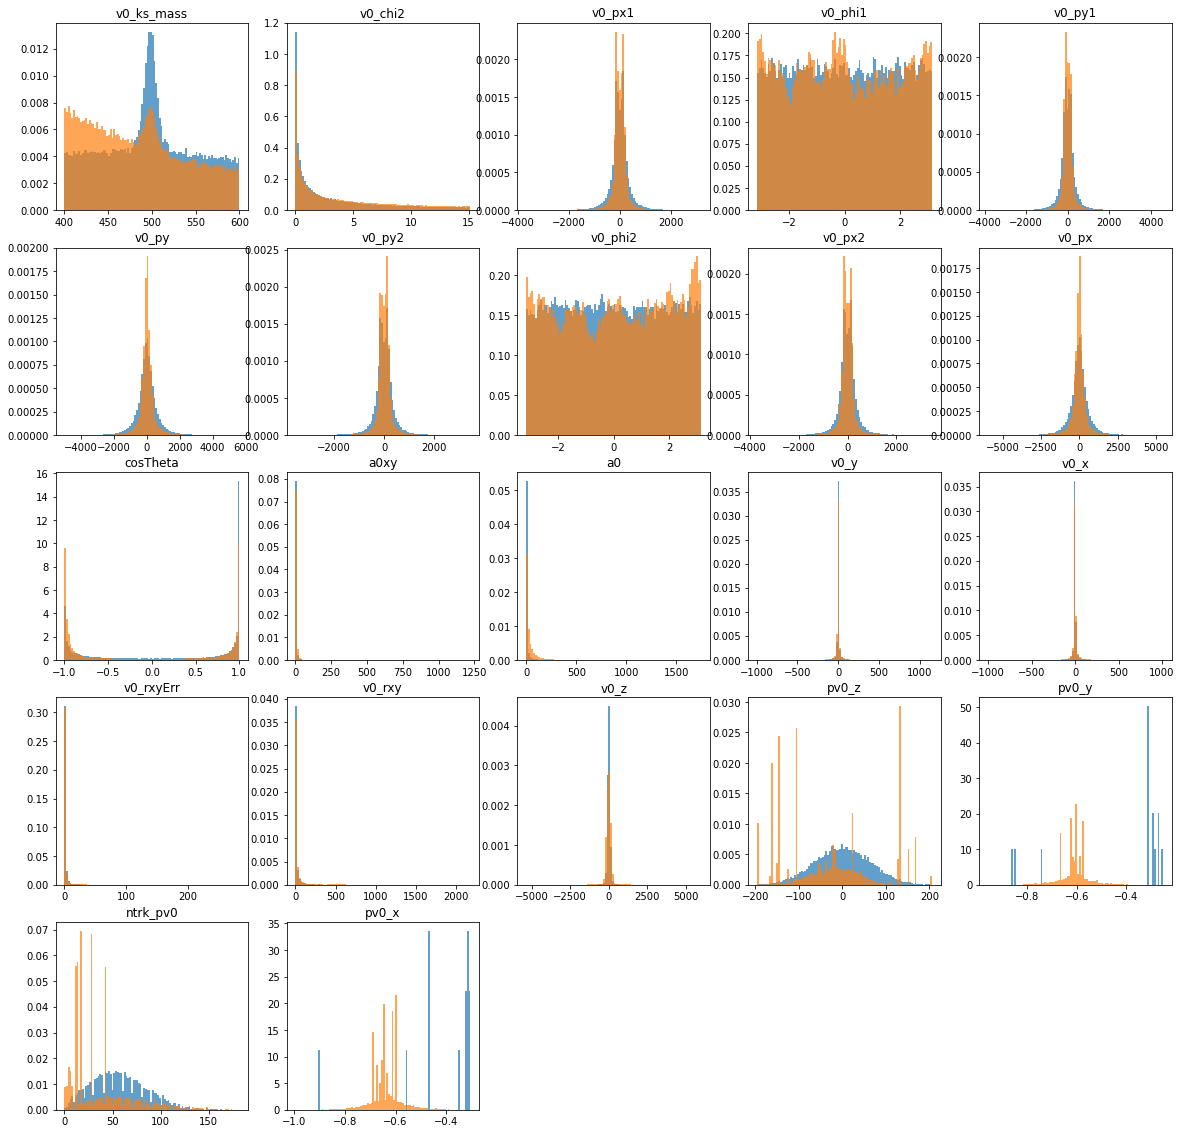

In [47]:
so, solist=draw_distributions(mc[all_features], data[all_features], np.ones(len(mc)))

In [48]:
from sklearn.preprocessing import MinMaxScaler
def scale_split2(mcs, datas, split, quantile, paramlist, no_transform):
    mc1, data1=mcs[paramlist], datas[paramlist]
    testlen=int(len(mc)*(1-split))
    
    for param in paramlist:
        if param not in no_transform:
            print(param+' is being transformed' )
            q_mc, q_data = (mcs.quantile(1-quantile)[param], mcs.quantile(quantile)[param]), (datas.quantile(1-quantile)[param], datas.quantile(quantile)[param])
            mcq, dataq = mcs.loc[(mcs[param] > q_mc[0]) & (mcs[param] < q_mc[1])], datas.loc[(datas[param] > q_data[0]) & (datas[param] < q_data[1])]
            mcscaler, datascaler=MinMaxScaler().fit( (mcq[param]).to_numpy().reshape(-1, 1) ), MinMaxScaler().fit( (dataq[param]).to_numpy().reshape(-1, 1))  
            mcscaled, datascaled= mcscaler.transform( (mcs[param]).to_numpy().reshape(-1, 1) ), datascaler.transform( (datas[param]).to_numpy().reshape(-1, 1) ) 
            mc1[param], data1[param]=mcscaled, datascaled
    true=mc.trueKs
    return mc1[:testlen], mc1[testlen:], data1[:testlen], data1[testlen:], true[:testlen], true[testlen:]

In [49]:
uncorrelated=['v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2', 'v0_phi2','v0_px2', 'v0_px', 
              'cosTheta', 'a0xy', 'a0', 'v0_y', 'v0_x', 'v0_rxyErr', 'v0_rxy','v0_z', 'pv0_z', 'pv0_y', 'ntrk_pv0', 'pv0_x']
mc_test, mc_train, data_test, data_train, truetest, truetrain=scale_split2(mc, data, 
                    0.7, 0.78, np.hstack((uncorrelated, ['v0_ks_mass'])), ['v0_chi2','v0_ks_mass', 'cosTheta'])

v0_px1 is being transformed
v0_phi1 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py1 is being transformed
v0_py is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py2 is being transformed
v0_phi2 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px2 is being transformed
v0_px is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


a0xy is being transformed
a0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_y is being transformed
v0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_rxyErr is being transformed
v0_rxy is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_z is being transformed
pv0_z is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_y is being transformed
ntrk_pv0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
ses=[]
for i in range(70,80):
    split=i/100
    mc_test, mc_train, data_test, data_train, truetest, truetrain=scale_split2(mc, data, 
                    0.7, split, np.hstack((uncorrelated, ['v0_ks_mass'])), ['v0_chi2','v0_ks_mass', 'cosTheta'])
    s1, s1list=compare_distributions(mc_train, data_train, np.ones(len(mc_train)))
    ses.append(s1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px1 is being transformed
v0_phi1 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py1 is being transformed
v0_py is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py2 is being transformed
v0_phi2 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px2 is being transformed
v0_px is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


a0xy is being transformed
a0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_y is being transformed
v0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_rxyErr is being transformed
v0_rxy is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_z is being transformed
pv0_z is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_y is being transformed
ntrk_pv0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_x is being transformed
v0_px1 is being transformed
v0_phi1 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py1 is being transformed
v0_py is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py2 is being transformed
v0_phi2 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px2 is being transformed
v0_px is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


a0xy is being transformed
a0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_y is being transformed
v0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_rxyErr is being transformed
v0_rxy is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_z is being transformed
pv0_z is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_y is being transformed
ntrk_pv0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px1 is being transformed
v0_phi1 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py1 is being transformed
v0_py is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py2 is being transformed
v0_phi2 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px2 is being transformed
v0_px is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


a0xy is being transformed
a0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_y is being transformed
v0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_rxyErr is being transformed
v0_rxy is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_z is being transformed
pv0_z is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_y is being transformed
ntrk_pv0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px1 is being transformed
v0_phi1 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py1 is being transformed
v0_py is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py2 is being transformed
v0_phi2 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px2 is being transformed
v0_px is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


a0xy is being transformed
a0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_y is being transformed
v0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_rxyErr is being transformed
v0_rxy is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_z is being transformed
pv0_z is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_y is being transformed
ntrk_pv0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px1 is being transformed
v0_phi1 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py1 is being transformed
v0_py is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py2 is being transformed
v0_phi2 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px2 is being transformed
v0_px is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


a0xy is being transformed
a0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_y is being transformed
v0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_rxyErr is being transformed
v0_rxy is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_z is being transformed
pv0_z is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_y is being transformed
ntrk_pv0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px1 is being transformed
v0_phi1 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py1 is being transformed
v0_py is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py2 is being transformed
v0_phi2 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px2 is being transformed
v0_px is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


a0xy is being transformed
a0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_y is being transformed
v0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_rxyErr is being transformed
v0_rxy is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_z is being transformed
pv0_z is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_y is being transformed
ntrk_pv0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px1 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_phi1 is being transformed
v0_py1 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py is being transformed
v0_py2 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_phi2 is being transformed
v0_px2 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px is being transformed
a0xy is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


a0 is being transformed
v0_y is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_x is being transformed
v0_rxyErr is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_rxy is being transformed
v0_z is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_z is being transformed
pv0_y is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ntrk_pv0 is being transformed
pv0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px1 is being transformed
v0_phi1 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py1 is being transformed
v0_py is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py2 is being transformed
v0_phi2 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px2 is being transformed
v0_px is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


a0xy is being transformed
a0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_y is being transformed
v0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_rxyErr is being transformed
v0_rxy is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_z is being transformed
pv0_z is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_y is being transformed
ntrk_pv0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px1 is being transformed
v0_phi1 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py1 is being transformed
v0_py is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py2 is being transformed
v0_phi2 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px2 is being transformed
v0_px is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


a0xy is being transformed
a0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_y is being transformed
v0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_rxyErr is being transformed
v0_rxy is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_z is being transformed
pv0_z is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_y is being transformed
ntrk_pv0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px1 is being transformed
v0_phi1 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py1 is being transformed
v0_py is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py2 is being transformed
v0_phi2 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px2 is being transformed
v0_px is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


a0xy is being transformed
a0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_y is being transformed
v0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_rxyErr is being transformed
v0_rxy is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_z is being transformed
pv0_z is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_y is being transformed
ntrk_pv0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


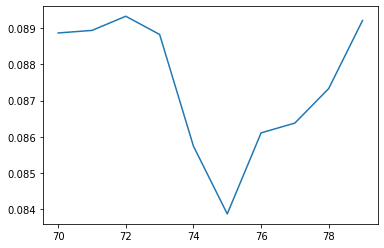

In [51]:
plt.plot(range(70,80),ses)

In [52]:
features=np.hstack((['v0_ks_mass'], uncorrelated))
mc_test, mc_train, data_test, data_train, truetest, truetrain=scale_split2(mc, data, 
                    0.78, split, features, ['v0_chi2','v0_ks_mass', 'cosTheta'])

v0_px1 is being transformed
v0_phi1 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py1 is being transformed
v0_py is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py2 is being transformed
v0_phi2 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px2 is being transformed
v0_px is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


a0xy is being transformed
a0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_y is being transformed
v0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_rxyErr is being transformed
v0_rxy is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_z is being transformed
pv0_z is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_y is being transformed
ntrk_pv0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_ks_mass
KS over  v0_ks_mass  =  0.16088184187656374
v0_chi2
KS over  v0_chi2  =  0.08976976542139681
v0_px1
KS over  v0_px1  =  0.052193744569933254
v0_phi1
KS over  v0_phi1  =  0.06705039096443544
v0_py1
KS over  v0_py1  =  0.07113379669858277
v0_py
KS over  v0_py  =  0.08512163336236556
v0_py2
KS over  v0_py2  =  0.05540834057346111
v0_phi2
KS over  v0_phi2  =  0.03338401390098367
v0_px2
KS over  v0_px2  =  0.04385317115555398
v0_px
KS over  v0_px  =  0.03481754995654435
cosTheta
KS over  cosTheta  =  0.21952649869670954
a0xy
KS over  a0xy  =  0.11909209383139935
a0
KS over  a0  =  0.06361859252823697
v0_y
KS over  v0_y  =  0.040682015638557556
v0_x
KS over  v0_x  =  0.03672893136401545
v0_rxyErr
KS over  v0_rxyErr  =  0.028692441355349096
v0_rxy
KS over  v0_rxy  =  0.04676368375329765
v0_z
KS over  v0_z  =  0.05579930495226293
pv0_z
KS over  pv0_z  =  0.21602953953084145
pv0_y
KS over  pv0_y  =  0.28751086012161675
ntrk_pv0
KS over  ntrk_pv0  =  0.24148566463944882
pv0_x
KS over 

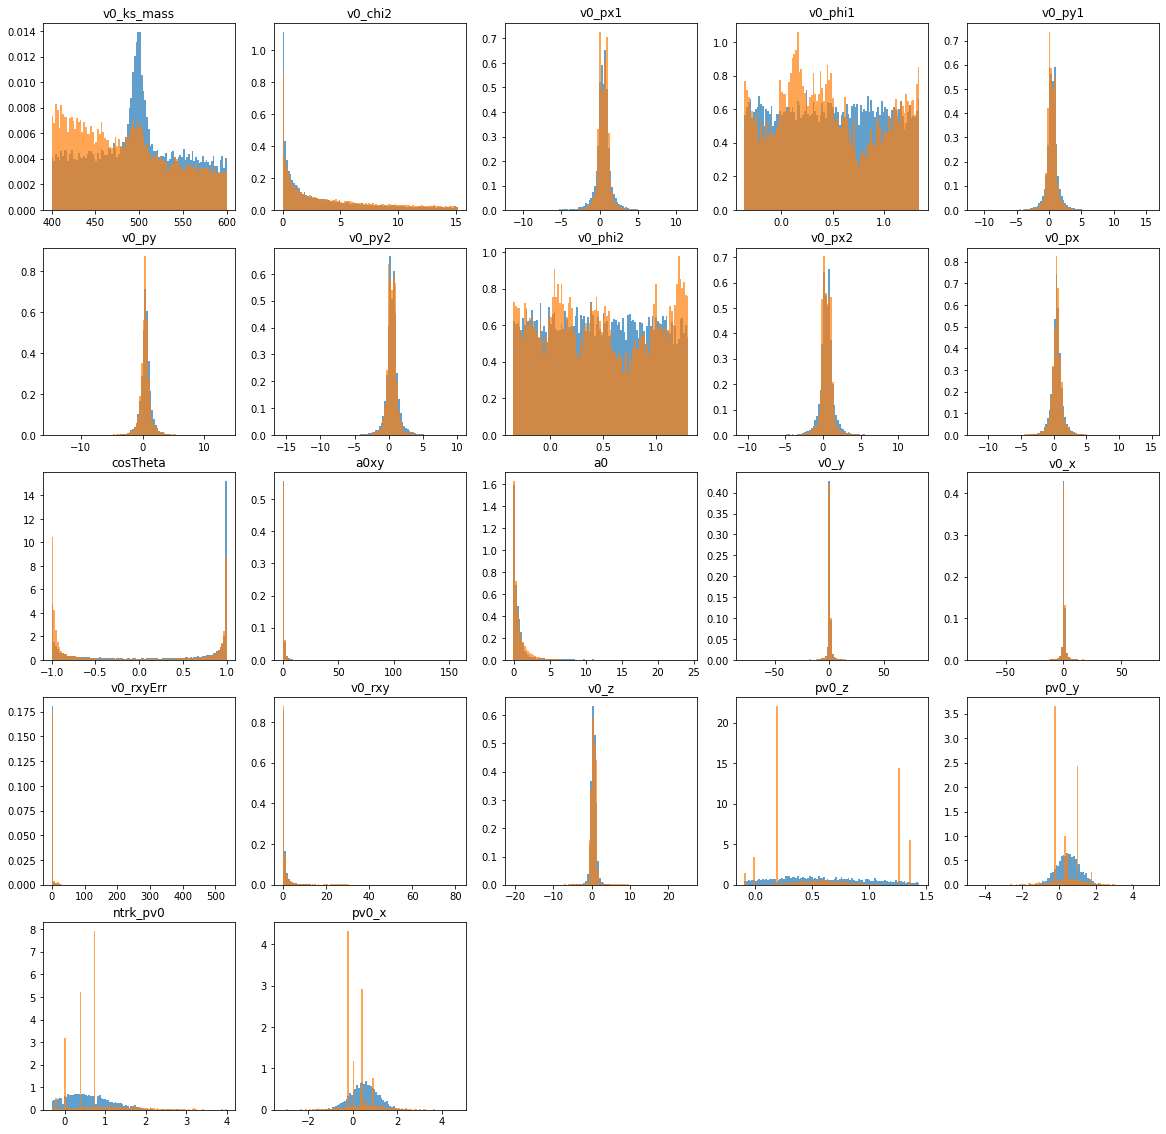

In [53]:
sn, snlist=draw_distributions(mc_test, data_test, np.ones(len(mc_test)))

array(['v0_ks_mass', 'v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py',
       'v0_py2', 'v0_phi2', 'v0_px2', 'v0_px', 'cosTheta', 'a0xy', 'a0',
       'v0_y', 'v0_x', 'v0_rxyErr', 'v0_rxy', 'v0_z', 'pv0_z', 'pv0_y',
       'ntrk_pv0', 'pv0_x'], dtype='<U10')

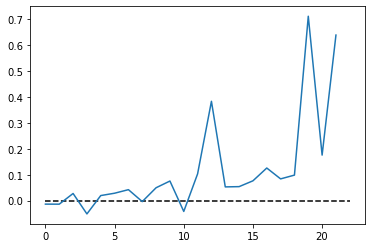

In [54]:
plt.plot(np.array(solist)-np.array(snlist))
plt.hlines(0, 0,22, linestyle='dashed')
all_features

In [55]:
so/sn

2.0871580090950266

# let's do ml1/ml2 and ml1+ml2

In [56]:
print(all_features)

['v0_ks_mass' 'v0_chi2' 'v0_px1' 'v0_phi1' 'v0_py1' 'v0_py' 'v0_py2'
 'v0_phi2' 'v0_px2' 'v0_px' 'cosTheta' 'a0xy' 'a0' 'v0_y' 'v0_x'
 'v0_rxyErr' 'v0_rxy' 'v0_z' 'pv0_z' 'pv0_y' 'ntrk_pv0' 'pv0_x']


In [57]:
reweighter12 = GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=5, min_samples_leaf=1000)
reweighter12.fit(mc_train[all_features], data_train[all_features])

GBReweighter(gb_args={}, learning_rate=0.1, max_depth=5, min_samples_leaf=1000,
             n_estimators=50)

v0_ks_mass
KS over  v0_ks_mass  =  0.1202524370979541
v0_chi2
KS over  v0_chi2  =  0.12967159652936
v0_px1
KS over  v0_px1  =  0.09946980389546778
v0_phi1
KS over  v0_phi1  =  0.11251928646470488
v0_py1
KS over  v0_py1  =  0.10772516456265224
v0_py
KS over  v0_py  =  0.13508910114866857
v0_py2
KS over  v0_py2  =  0.09940961916794377
v0_phi2
KS over  v0_phi2  =  0.08924930841265144
v0_px2
KS over  v0_px2  =  0.06992596003152185
v0_px
KS over  v0_px  =  0.056505602214251494
cosTheta
KS over  cosTheta  =  0.09586813044662029
a0xy
KS over  a0xy  =  0.1164856646394388
a0
KS over  a0  =  0.07559187360901753
v0_y
KS over  v0_y  =  0.10702221364983155
v0_x
KS over  v0_x  =  0.11494001001651688
v0_rxyErr
KS over  v0_rxyErr  =  0.08910778779217965
v0_rxy
KS over  v0_rxy  =  0.11363211175886745
v0_z
KS over  v0_z  =  0.13152746156390915
pv0_z
KS over  pv0_z  =  0.2681575428569597
pv0_y
KS over  pv0_y  =  0.32048586167356585
ntrk_pv0
KS over  ntrk_pv0  =  0.4018678532918095
pv0_x
KS over  pv0_x  =

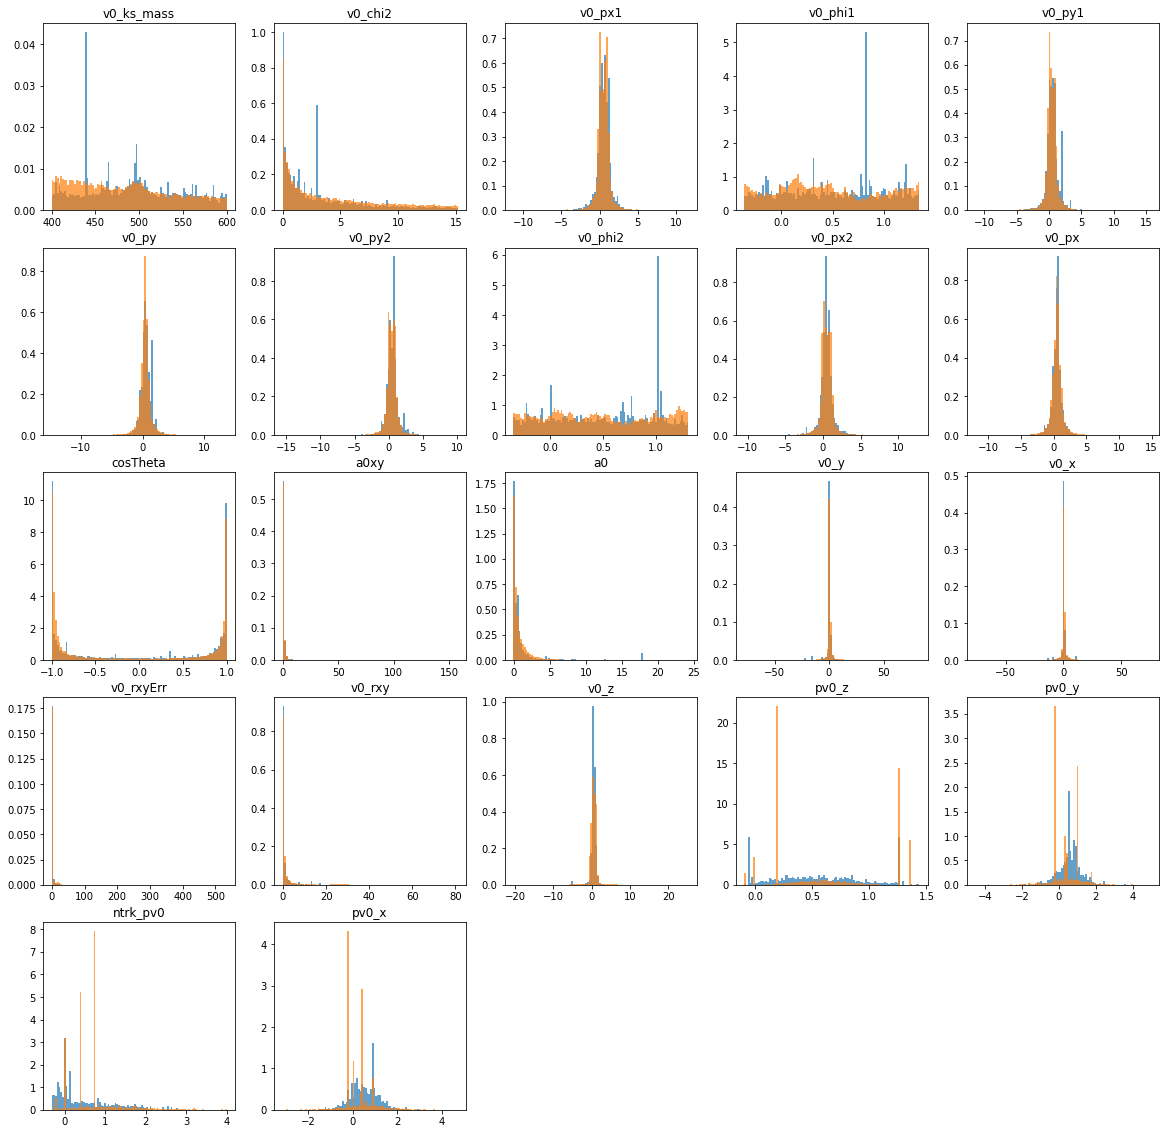

In [58]:
gb_weights_test = reweighter12.predict_weights(mc_test[features])
# validate reweighting rule on the test part comparing 1d projections
s12, _ =draw_distributions(mc_test[features], data_test[features], gb_weights_test, verbose=1)

In [59]:
#need to get mass in on both
ML1, ML2=np.hstack((['v0_ks_mass'], ml1)), np.hstack((['v0_ks_mass'], ml2))

In [60]:
reweighter1 = GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=5, min_samples_leaf=1000)
reweighter1.fit(mc_train[ML1], data_train[ML1])

GBReweighter(gb_args={}, learning_rate=0.1, max_depth=5, min_samples_leaf=1000,
             n_estimators=50)

v0_ks_mass
KS over  v0_ks_mass  =  0.04231962591046268
v0_chi2
KS over  v0_chi2  =  0.04696461713861755
v0_px1
KS over  v0_px1  =  0.04268934873050545
v0_phi1
KS over  v0_phi1  =  0.07317402911199389
v0_py1
KS over  v0_py1  =  0.07995230486478055
v0_py
KS over  v0_py  =  0.09442490486498245
v0_py2
KS over  v0_py2  =  0.060792286332169154
v0_phi2
KS over  v0_phi2  =  0.041677677457668705
v0_px2
KS over  v0_px2  =  0.03343108640558147
v0_px
KS over  v0_px  =  0.056565636327489566


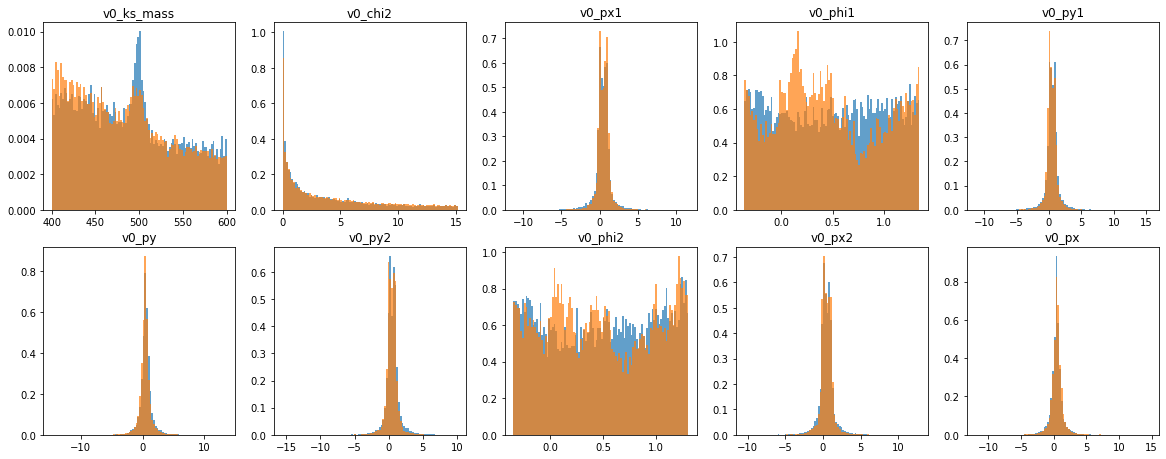

In [61]:
gb_weights1 = reweighter1.predict_weights(mc_test[ML1])
# validate reweighting rule on the test part comparing 1d projections
s1, _ =draw_distributions(mc_test[ML1], data_test[ML1], gb_weights1, verbose=1)

In [62]:
reweighter2 = GBReweighter(n_estimators=100, learning_rate=0.1, max_depth=5, min_samples_leaf=1000)
reweighter2.fit(mc_train[ML2], data_train[ML2])

GBReweighter(gb_args={}, learning_rate=0.1, max_depth=5, min_samples_leaf=1000,
             n_estimators=100)

v0_ks_mass
KS over  v0_ks_mass  =  0.34904430841825457
cosTheta
KS over  cosTheta  =  0.24428396586027862
a0xy
KS over  a0xy  =  0.6185273665672366
a0
KS over  a0  =  0.3257797024589076
v0_y
KS over  v0_y  =  0.29999999915394304
v0_x
KS over  v0_x  =  0.446394438674512
v0_rxyErr
KS over  v0_rxyErr  =  0.27497689572509454
v0_rxy
KS over  v0_rxy  =  0.4540109732171837
v0_z
KS over  v0_z  =  0.9500651595863391
pv0_z
KS over  pv0_z  =  0.9999999988337213
pv0_y
KS over  pv0_y  =  0.673327540152548
ntrk_pv0
KS over  ntrk_pv0  =  0.8957428311822939
pv0_x
KS over  pv0_x  =  0.5079278887096362


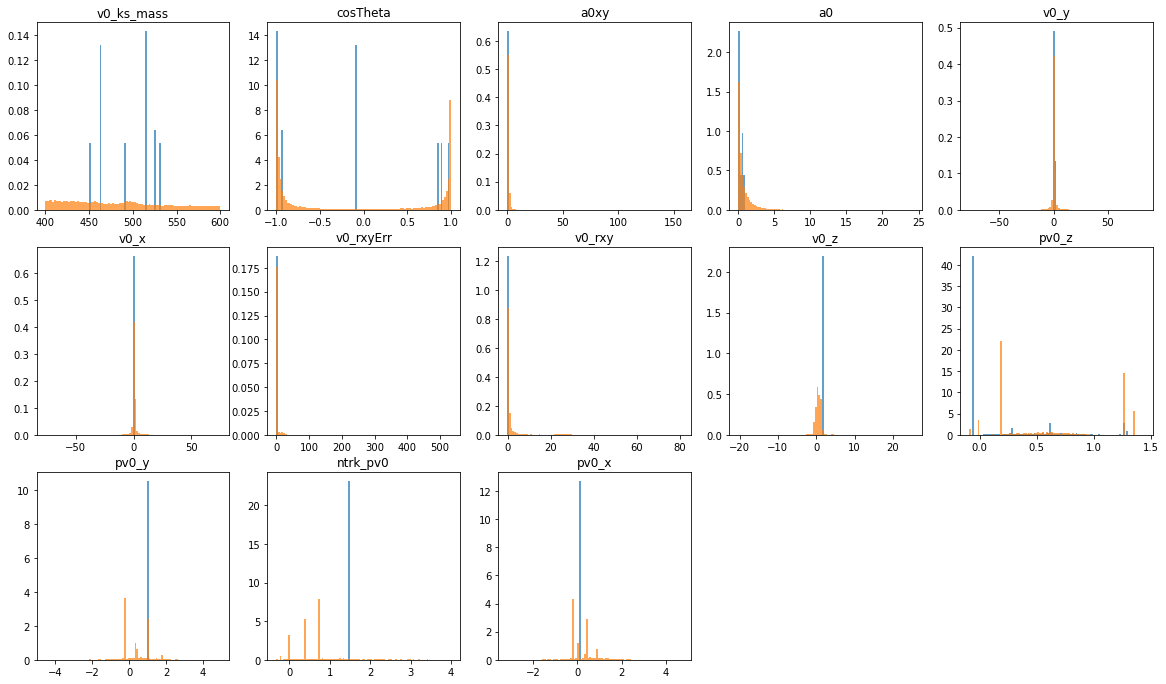

In [63]:
gb_weights2 = reweighter2.predict_weights(mc_test[ML2])
# validate reweighting rule on the test part comparing 1d projections
s2, _ =draw_distributions(mc_test[ML2], data_test[ML2], gb_weights2, verbose=1)

Alright so it's ml2 that's fucking shit up. Let's find out where.

In [64]:
slist=[]
check=['v0_ks_mass','cosTheta','a0xy','a0','v0_y','v0_x','v0_rxyErr','v0_rxy','v0_z']
extra=['pv0_z','pv0_y','ntrk_pv0','pv0_x']
for e in extra:
    tot=np.hstack((check, e))
    rw = GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=5, min_samples_leaf=1000)
    rw.fit(mc_train[tot], data_train[tot])
    weightstest = rw.predict_weights(mc_test[tot])
    # validate reweighting rule on the test part comparing 1d projections
    ss, _ =draw_distributions(mc_test[tot], data_test[tot], weightstest, verbose=0, plot=0)
    slist.append(ss)

v0_ks_mass
cosTheta
a0xy
a0
v0_y
v0_x
v0_rxyErr
v0_rxy
v0_z
pv0_z
v0_ks_mass
cosTheta
a0xy
a0
v0_y
v0_x
v0_rxyErr
v0_rxy
v0_z
pv0_y
v0_ks_mass
cosTheta
a0xy
a0
v0_y
v0_x
v0_rxyErr
v0_rxy
v0_z
ntrk_pv0
v0_ks_mass
cosTheta
a0xy
a0
v0_y
v0_x
v0_rxyErr
v0_rxy
v0_z
pv0_x


<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

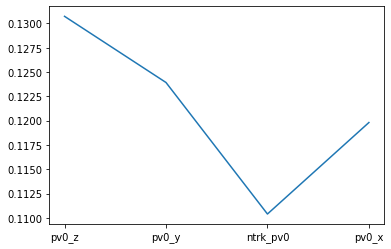

In [65]:
plt.plot(extra, slist)

So we can probably keep ntrk_pv0 and pv0_x but it turns out that keeping both is bad

Let's also try removing a0 since most of that information is in a0xy

In [66]:
ML2=['v0_ks_mass','cosTheta','v0_y','v0_x','v0_rxyErr','v0_rxy','v0_z', 'ntrk_pv0', 'a0xy']
obsolote=[ 'pv0_x','pv0_z','pv0_x', 'a0xy','a0']
reweighter2 = GBReweighter(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=1000)
reweighter2.fit(mc_train[ML2], data_train[ML2])

GBReweighter(gb_args={}, learning_rate=0.1, max_depth=4, min_samples_leaf=1000,
             n_estimators=100)

v0_ks_mass
KS over  v0_ks_mass  =  0.09598989319678608
cosTheta
KS over  cosTheta  =  0.1250919572894022
v0_y
KS over  v0_y  =  0.07324685142958287
v0_x
KS over  v0_x  =  0.06040890648723196
v0_rxyErr
KS over  v0_rxyErr  =  0.04469254374509535
v0_rxy
KS over  v0_rxy  =  0.1013211340027711
v0_z
KS over  v0_z  =  0.10806966185352807
ntrk_pv0
KS over  ntrk_pv0  =  0.2917605750978572
a0xy
KS over  a0xy  =  0.1164856646394388


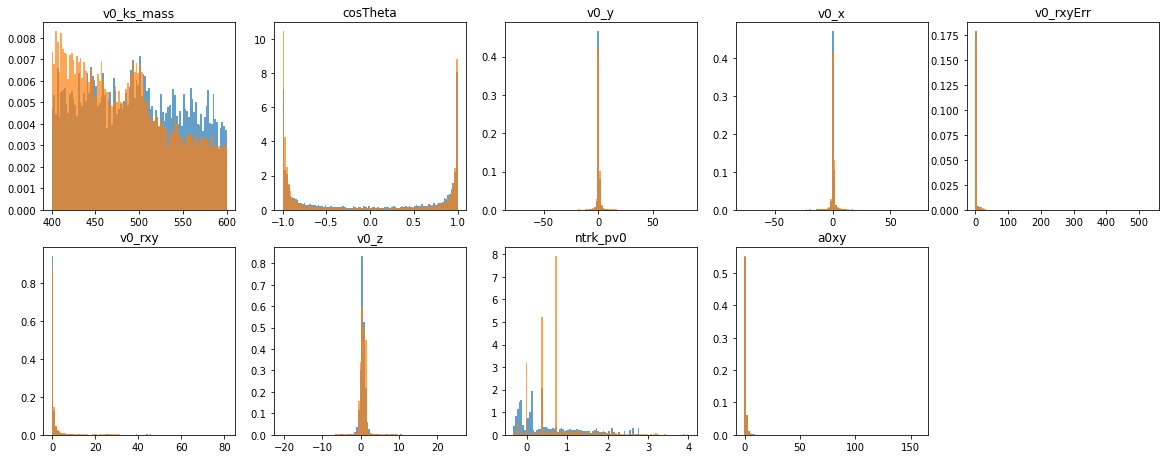

In [67]:
gb_weights2 = reweighter2.predict_weights(mc_test[ML2])
# validate reweighting rule on the test part comparing 1d projections
s2, _ =draw_distributions(mc_test[ML2], data_test[ML2], gb_weights2, verbose=1)

Throw out a0xy and keep ntrk_pv0

Let's try the whole thing while still drawing the obsolete parameters 

cosTheta
KS over  cosTheta  =  0.1250919572894022
a0xy
KS over  a0xy  =  0.1164856646394388
a0
KS over  a0  =  0.04688039688987666
v0_y
KS over  v0_y  =  0.07324685142958287
v0_x
KS over  v0_x  =  0.06040890648723196
v0_rxyErr
KS over  v0_rxyErr  =  0.04469254374509535
v0_rxy
KS over  v0_rxy  =  0.1013211340027711
v0_z
KS over  v0_z  =  0.10806966185352807
pv0_z
KS over  pv0_z  =  0.21810665127411666
pv0_y
KS over  pv0_y  =  0.28442423877141154
ntrk_pv0
KS over  ntrk_pv0  =  0.2917605750978572
pv0_x
KS over  pv0_x  =  0.3675694613166366


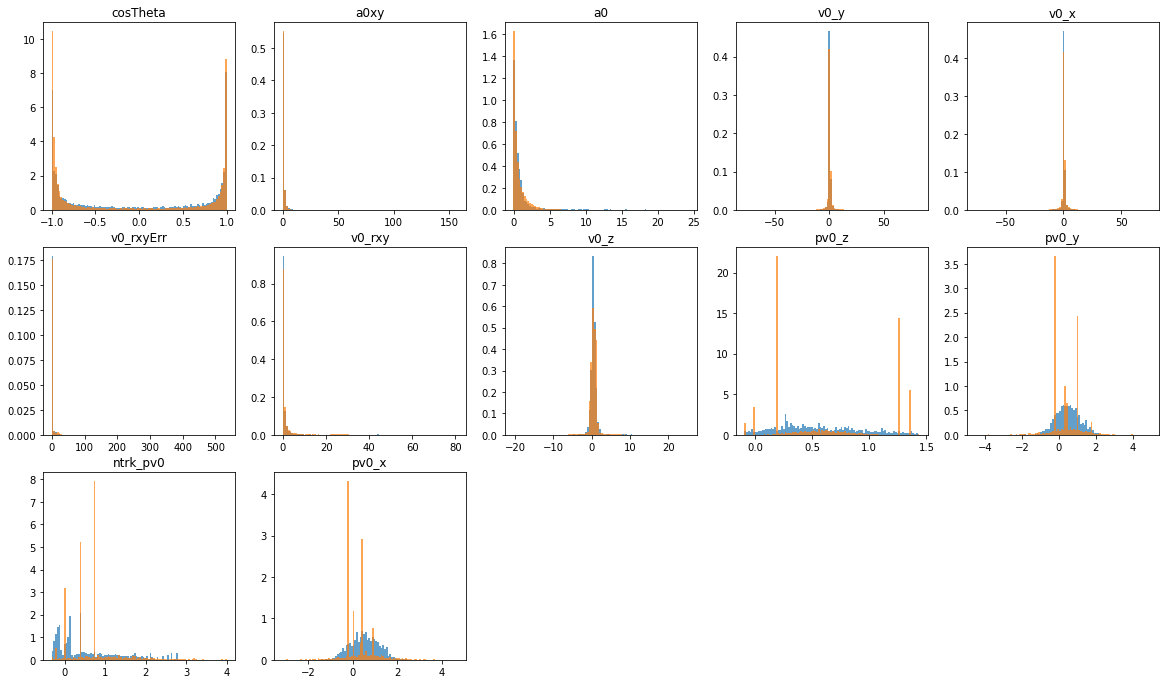

In [68]:
# validate reweighting rule on the test part comparing 1d projections
s2, _ =draw_distributions(mc_test[ml2], data_test[ml2], gb_weights2, verbose=1)

Let's get the reweighter for the whole thing ml1+ml2

v0_ks_mass
KS over  v0_ks_mass  =  0.135628706837215
v0_chi2
KS over  v0_chi2  =  0.09679640973897219
v0_px1
KS over  v0_px1  =  0.04685767150162566
v0_phi1
KS over  v0_phi1  =  0.05992383144957836
v0_py1
KS over  v0_py1  =  0.06497803283358339
v0_py
KS over  v0_py  =  0.08037697439321856
v0_py2
KS over  v0_py2  =  0.05255114545010253
v0_phi2
KS over  v0_phi2  =  0.04096401679117534
v0_px2
KS over  v0_px2  =  0.06061989269762802
v0_px
KS over  v0_px  =  0.04121007945374022
cosTheta
KS over  cosTheta  =  0.1375357696479942
v0_y
KS over  v0_y  =  0.09366845069805985
v0_x
KS over  v0_x  =  0.08059483784357047
v0_rxyErr
KS over  v0_rxyErr  =  0.043445790399692985
v0_rxy
KS over  v0_rxy  =  0.14628725665636977
v0_z
KS over  v0_z  =  0.10127696163693933
ntrk_pv0
KS over  ntrk_pv0  =  0.2250831309006131
a0
KS over  a0  =  0.20294648879059007


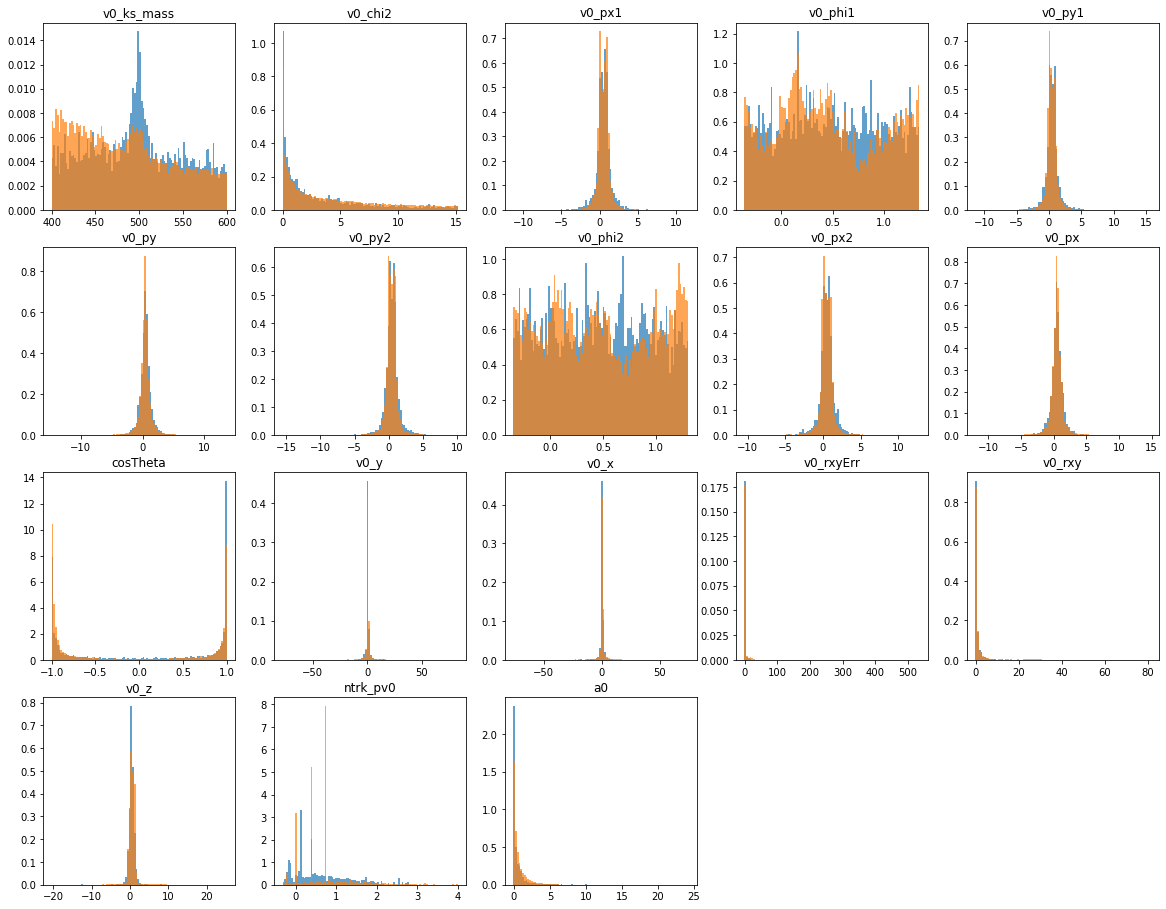

In [69]:
train_features=['v0_ks_mass', 'v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py',
       'v0_py2', 'v0_phi2', 'v0_px2', 'v0_px', 'cosTheta',
       'v0_y', 'v0_x', 'v0_rxyErr', 'v0_rxy', 'v0_z', 'ntrk_pv0', 'a0']
reweighter12 = GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=5, min_samples_leaf=1000)
reweighter12.fit(mc_train[train_features], data_train[train_features])

gb_weights_test = reweighter12.predict_weights(mc_test[train_features])
# validate reweighting rule on the test part comparing 1d projections
s12, _ =draw_distributions(mc_test[train_features], data_test[train_features], gb_weights_test, verbose=1)

v0_ks_mass
KS over  v0_ks_mass  =  0.135628706837215
v0_chi2
KS over  v0_chi2  =  0.09679640973897219
v0_px1
KS over  v0_px1  =  0.04685767150162566
v0_phi1
KS over  v0_phi1  =  0.05992383144957836
v0_py1
KS over  v0_py1  =  0.06497803283358339
v0_py
KS over  v0_py  =  0.08037697439321856
v0_py2
KS over  v0_py2  =  0.05255114545010253
v0_phi2
KS over  v0_phi2  =  0.04096401679117534
v0_px2
KS over  v0_px2  =  0.06061989269762802
v0_px
KS over  v0_px  =  0.04121007945374022
cosTheta
KS over  cosTheta  =  0.1375357696479942
a0xy
KS over  a0xy  =  0.2585871534459285
a0
KS over  a0  =  0.20294648879059007
v0_y
KS over  v0_y  =  0.09366845069805985
v0_x
KS over  v0_x  =  0.08059483784357047
v0_rxyErr
KS over  v0_rxyErr  =  0.043445790399692985
v0_rxy
KS over  v0_rxy  =  0.14628725665636977
v0_z
KS over  v0_z  =  0.10127696163693933
pv0_z
KS over  pv0_z  =  0.20982462292307025
pv0_y
KS over  pv0_y  =  0.27751665794069014
ntrk_pv0
KS over  ntrk_pv0  =  0.2250831309006131
pv0_x
KS over  pv0_x 

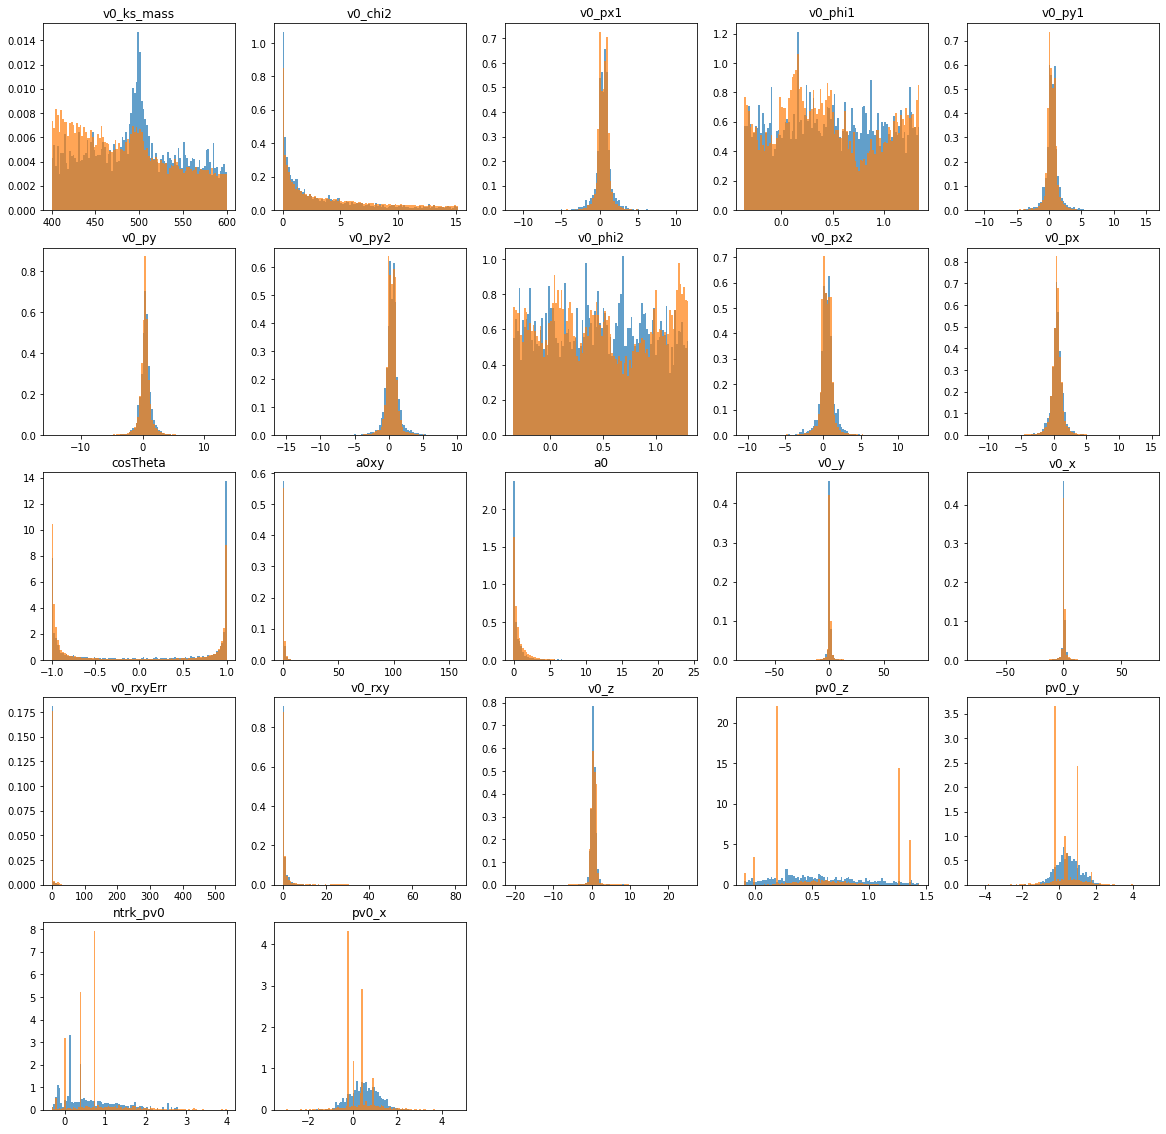

In [70]:
s12, _ =draw_distributions(mc_test[all_features], data_test[all_features], gb_weights_test, verbose=1)

In [71]:
s1, s2, s12, so

(0.05719915171442515,
 0.1531715035664124,
 0.1278899728340062,
 0.22862548486405992)

Testing whether xgboost can see the difference for the three scenarios

Let's check ML1
- can we make a classifier that can tell the difference?
- how does prediction for this do if we;

1: Do not reweigh MC and use it in data

2: Reweigh MC

In [72]:
train_weights1 = reweighter1.predict_weights(mc_train[ML1])
test_weights1 = reweighter1.predict_weights(mc_test[ML1])
eval_weights1=[np.hstack((np.ones(len(data_train)), train_weights1)), np.hstack((np.ones(len(data_test)), test_weights1))]

In [73]:
import xgboost
eval_s = [(pd.concat((data_train[ml1], mc_train[ml1])), np.hstack((np.ones(len(data_train)), np.zeros(len(mc_train))))), 
          (pd.concat((data_test[ml1], mc_test[ml1])),  np.hstack((np.ones(len(data_test)), np.zeros(len(mc_test)))))]
modelw1 = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modelw1.fit(pd.concat((data_train[ml1], mc_train[ml1])), np.hstack((np.ones(len(data_train)), np.zeros(len(mc_train)))), 
            sample_weight=eval_weights1[0], eval_set=eval_s, sample_weight_eval_set=eval_weights1,
            verbose=True, early_stopping_rounds=30,eval_metric ="auc")

[0]	validation_0-auc:0.528907	validation_1-auc:0.532839
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.528934	validation_1-auc:0.532856
[2]	validation_0-auc:0.534621	validation_1-auc:0.53191
[3]	validation_0-auc:0.53419	validation_1-auc:0.52992
[4]	validation_0-auc:0.541046	validation_1-auc:0.537566
[5]	validation_0-auc:0.542685	validation_1-auc:0.539369
[6]	validation_0-auc:0.542056	validation_1-auc:0.539224
[7]	validation_0-auc:0.542197	validation_1-auc:0.539699
[8]	validation_0-auc:0.542155	validation_1-auc:0.539696
[9]	validation_0-auc:0.542528	validation_1-auc:0.539516
[10]	validation_0-auc:0.542647	validation_1-auc:0.53965
[11]	validation_0-auc:0.542708	validation_1-auc:0.539706
[12]	validation_0-auc:0.542215	validation_1-auc:0.539592
[13]	validation_0-auc:0.542168	validation_1-auc:0.539553
[14]	validation_0-auc:0.542151	validation_1-auc:0.539583
[1

[142]	validation_0-auc:0.7423	validation_1-auc:0.716271
[143]	validation_0-auc:0.743201	validation_1-auc:0.717133
[144]	validation_0-auc:0.742732	validation_1-auc:0.716232
[145]	validation_0-auc:0.74298	validation_1-auc:0.716462
[146]	validation_0-auc:0.743426	validation_1-auc:0.716923
[147]	validation_0-auc:0.744099	validation_1-auc:0.717776
[148]	validation_0-auc:0.744169	validation_1-auc:0.71782
[149]	validation_0-auc:0.744373	validation_1-auc:0.71793
[150]	validation_0-auc:0.744568	validation_1-auc:0.718049
[151]	validation_0-auc:0.744602	validation_1-auc:0.718048
[152]	validation_0-auc:0.744872	validation_1-auc:0.718288
[153]	validation_0-auc:0.744764	validation_1-auc:0.718184
[154]	validation_0-auc:0.744789	validation_1-auc:0.718012
[155]	validation_0-auc:0.746234	validation_1-auc:0.719978
[156]	validation_0-auc:0.750883	validation_1-auc:0.723998
[157]	validation_0-auc:0.75091	validation_1-auc:0.723935
[158]	validation_0-auc:0.756659	validation_1-auc:0.728969
[159]	validation_0-a

XGBClassifier(learning_rate=0.02, n_estimators=200)

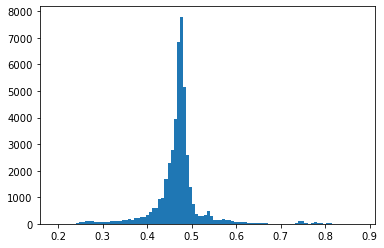

In [74]:
p1=modelw1.predict_proba(pd.concat((data_test[ml1], mc_test[ml1])))[:,0]
plt.hist(p1, bins=100)
truetest=np.hstack((np.ones(len(data_test)), np.zeros(len(mc_test))))

Text(0.5, 1.0, 'ROC curve for ML1, reweighed, AUC: 0.7712836493933806')

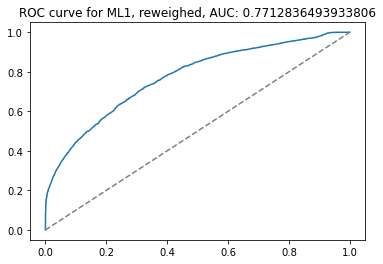

In [75]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true=truetest,
                                y_score=p1)

fig, ax = plt.subplots()
ax.plot(tpr,fpr)
ax.plot([0,1],[0,1],c='grey',linestyle='--')
ax.set_title(f'ROC curve for ML1, reweighed, AUC: {1-roc_auc_score(y_true=truetest,y_score=p1)}')

In [76]:
features=np.hstack((['v0_ks_mass'], uncorrelated))
uncorrelated=['v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2', 'v0_phi2','v0_px2', 'v0_px', 
              'cosTheta', 'a0xy', 'a0', 'v0_y', 'v0_x', 'v0_rxyErr', 'v0_rxy','v0_z', 'pv0_z', 'pv0_y', 'ntrk_pv0', 'pv0_x']
mc_test, mc_train, data_test, data_train, truetest, truetrain=scale_split2(mc, data, 
                    0.7, 0.78, np.hstack((uncorrelated, ['v0_ks_mass'])), ['v0_chi2','v0_ks_mass', 'cosTheta'])
eval_s1 = [(mc_train[ml1], truetrain), (mc_test[ml1], truetest)]
modeld1 = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modeld1.fit(mc_train[ml1], truetrain, verbose=True,eval_set=eval_s1, early_stopping_rounds=30,eval_metric ="auc")

v0_px1 is being transformed
v0_phi1 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py1 is being transformed
v0_py is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_py2 is being transformed
v0_phi2 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_px2 is being transformed
v0_px is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


a0xy is being transformed
a0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_y is being transformed
v0_x is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_rxyErr is being transformed
v0_rxy is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


v0_z is being transformed
pv0_z is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_y is being transformed
ntrk_pv0 is being transformed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pv0_x is being transformed
[0]	validation_0-auc:0.771003	validation_1-auc:0.767189
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[1]	validation_0-auc:0.78623	validation_1-auc:0.780226
[2]	validation_0-auc:0.78437	validation_1-auc:0.779531
[3]	validation_0-auc:0.790549	validation_1-auc:0.785999
[4]	validation_0-auc:0.789901	validation_1-auc:0.785725
[5]	validation_0-auc:0.79093	validation_1-auc:0.787063
[6]	validation_0-auc:0.790636	validation_1-auc:0.786892
[7]	validation_0-auc:0.79466	validation_1-auc:0.789691
[8]	validation_0-auc:0.79523	validation_1-auc:0.790659
[9]	validation_0-auc:0.798413	validation_1-auc:0.794354
[10]	validation_0-auc:0.799955	validation_1-auc:0.7956
[11]	validation_0-auc:0.801257	validation_1-auc:0.79681
[12]	validation_0-auc:0.801499	validation_1-auc:0.797369
[13]	validation_0-auc:0.80276	validation_1-auc:0.798019
[14]	validation_0-auc:0.802994	validation_1-auc:0.79838
[15]	validation_0-auc:0.803372	validation_1-auc:0.799301
[16]	validation_0-auc:0.803619	validation_1-auc:0.799823
[17]	validation_0-auc:0.804942	validation_1-auc:0.800573
[18]	validation_0-auc:0.804649	validation_1-auc:0.

[145]	validation_0-auc:0.825057	validation_1-auc:0.820048
[146]	validation_0-auc:0.825169	validation_1-auc:0.820132
[147]	validation_0-auc:0.825183	validation_1-auc:0.820172
[148]	validation_0-auc:0.82531	validation_1-auc:0.820305
[149]	validation_0-auc:0.825432	validation_1-auc:0.820414
[150]	validation_0-auc:0.825591	validation_1-auc:0.820546
[151]	validation_0-auc:0.825664	validation_1-auc:0.820635
[152]	validation_0-auc:0.825793	validation_1-auc:0.820737
[153]	validation_0-auc:0.825907	validation_1-auc:0.820863
[154]	validation_0-auc:0.826017	validation_1-auc:0.820973
[155]	validation_0-auc:0.82615	validation_1-auc:0.821093
[156]	validation_0-auc:0.826259	validation_1-auc:0.821244
[157]	validation_0-auc:0.826373	validation_1-auc:0.821395
[158]	validation_0-auc:0.826485	validation_1-auc:0.821522
[159]	validation_0-auc:0.826593	validation_1-auc:0.821606
[160]	validation_0-auc:0.82673	validation_1-auc:0.821734
[161]	validation_0-auc:0.826746	validation_1-auc:0.821761
[162]	validation_

XGBClassifier(learning_rate=0.02, n_estimators=200)

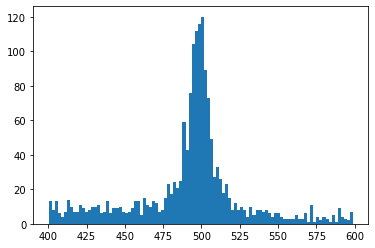

In [77]:
p1_d=modeld1.predict_proba((data_train[ml1]))[:,1]
true1_d=p1_d>0.5
plt.hist(data_train.v0_ks_mass[true1_d], bins=100);

0.8691319026608977

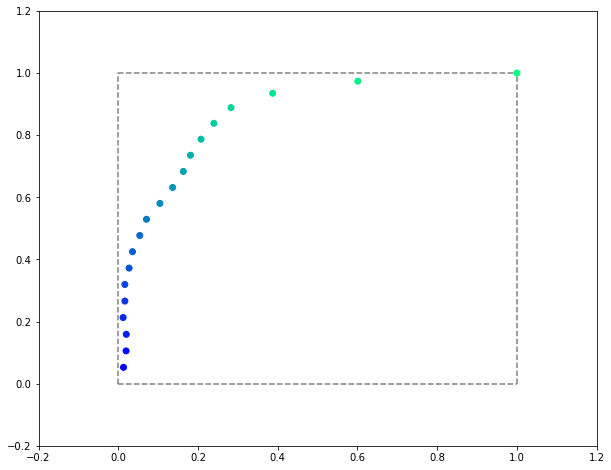

In [78]:
fig1, ax1=plt.subplots(figsize=(10,8))
a,b=hm.roc_curve_data(data_train.v0_ks_mass, 1-p1_d, Npoints = 20, bins = 100, range = (400, 600), ax_roc = ax1 ,\
             verbose = False, plimit = 0.9)
1+a

In [79]:
eval_weights1=[train_weights1, test_weights1]
eval_s1 = [(mc_train[ml1], truetrain)]

modeldw1 = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modeldw1.fit(mc_train[ml1], truetrain, sample_weight=train_weights1, verbose=True,eval_set=eval_s1, 
             sample_weight_eval_set=eval_weights1,early_stopping_rounds=30,eval_metric ="auc")

[0]	validation_0-auc:0.774461
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.774461
[2]	validation_0-auc:0.790214
[3]	validation_0-auc:0.791488
[4]	validation_0-auc:0.798177
[5]	validation_0-auc:0.800541
[6]	validation_0-auc:0.802281
[7]	validation_0-auc:0.803953
[8]	validation_0-auc:0.803355
[9]	validation_0-auc:0.80293
[10]	validation_0-auc:0.805096
[11]	validation_0-auc:0.804561
[12]	validation_0-auc:0.804494
[13]	validation_0-auc:0.805063
[14]	validation_0-auc:0.805355
[15]	validation_0-auc:0.805724
[16]	validation_0-auc:0.805658
[17]	validation_0-auc:0.805565
[18]	validation_0-auc:0.805875
[19]	validation_0-auc:0.806183
[20]	validation_0-auc:0.806226
[21]	validation_0-auc:0.806475
[22]	validation_0-auc:0.806967
[23]	validation_0-auc:0.807774
[24]	validation_0-auc:0.808055
[25]	validation_0-auc:0.808486
[26]	validation_0-auc:0.808796
[27]	validation_0-auc:0.808745
[28]	validation_0-auc:0.809525
[29]	validation_0-auc:0.810365
[30]	validation_0

XGBClassifier(learning_rate=0.02, n_estimators=200)

(array([23582.,  7142.,  8852.,  5726.,  1855.,  1632.,  1403.,   408.,
          288.,   619.]),
 array([0.02534551, 0.09628785, 0.16723019, 0.23817252, 0.30911484,
        0.3800572 , 0.45099953, 0.52194184, 0.5928842 , 0.6638265 ,
        0.73476887], dtype=float32),
 <a list of 10 Patch objects>)

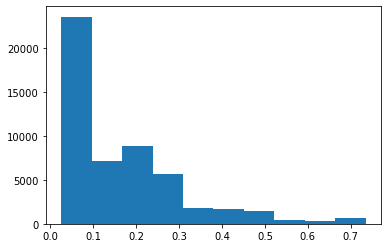

In [80]:
p1_dw=modeldw1.predict_proba((data_train[ml1]))[:,1]
true1_dw=p1_dw>0.5
plt.hist(p1_dw)

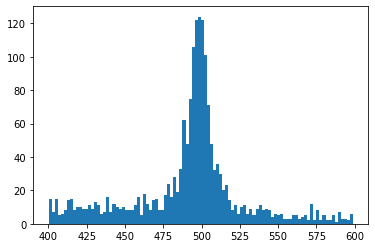

In [81]:
plt.hist(data_train.v0_ks_mass[true1_dw], bins=100);

0.8560459419482678

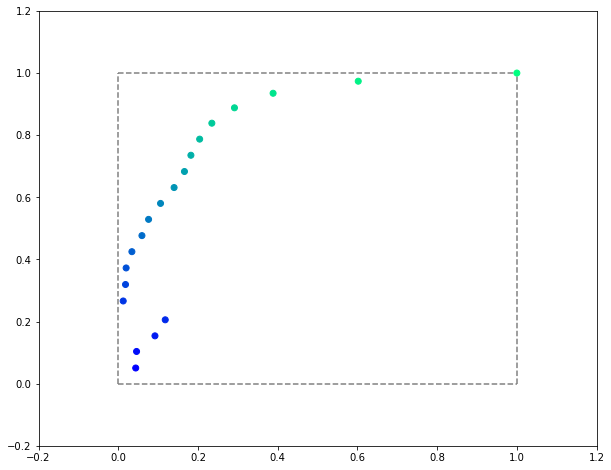

In [82]:
fig1, ax1=plt.subplots(figsize=(10,8))
a,b=hm.roc_curve_data(data_train.v0_ks_mass, 1-p1_dw, Npoints = 20, bins = 100, range = (400, 600), ax_roc = ax1 ,\
             verbose = False, plimit = 0.9)
1+a

Let's check ML2

In [83]:
train_weights2 = reweighter2.predict_weights(mc_train[ML2])
test_weights2 = reweighter2.predict_weights(mc_test[ML2])
eval_weights2=[np.hstack((np.ones(len(data_train)), train_weights2)), np.hstack((np.ones(len(data_test)), test_weights2))]

In [ ]:
eval_s2 = [(pd.concat((data_train[ml2], mc_train[ml2])), np.hstack((np.ones(len(data_train)), np.zeros(len(mc_train))))), 
          (pd.concat((data_test[ml2], mc_test[ml2])),  np.hstack((np.ones(len(data_test)), np.zeros(len(mc_test)))))]
modelw2 = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modelw2.fit(pd.concat((data_train[ml2], mc_train[ml2])), np.hstack((np.ones(len(data_train)), np.zeros(len(mc_train)))), 
            sample_weight=eval_weights1[0], eval_set=eval_s2, sample_weight_eval_set=eval_weights2,
            verbose=True, early_stopping_rounds=30,eval_metric ="auc")

In [ ]:
p2=modelw2.predict_proba(pd.concat((data_test[ml2], mc_test[ml2])))[:,0]
plt.hist(p2, bins=100)
true_test=np.hstack((np.ones(len(data_test)), np.zeros(len(mc_test))))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true=true_test,
                                y_score=p2)

fig, ax = plt.subplots()
ax.plot(tpr,fpr)
ax.plot([0,1],[0,1],c='grey',linestyle='--')
ax.set_title(f'ROC curve for ML2, reweighed, AUC: {1-roc_auc_score(y_true=true_test,y_score=p2)}')

In [ ]:
eval_s2 = [(mc_train[ml2], truetrain), (mc_test[ml2], truetest)]
modeld2 = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modeld2.fit(mc_train[ml2], truetrain, verbose=True,eval_set=eval_s2, early_stopping_rounds=30,eval_metric ="auc")

In [ ]:
p2_d=modeld2.predict_proba((data_train[ml2]))[:,1]
true2_d=p2_d>0.7
plt.hist(p2_d)

In [ ]:
plt.hist(data_train.v0_ks_mass[true2_d], bins=100);

In [ ]:
fig1, ax1=plt.subplots(figsize=(10,8))
a,b=hm.roc_curve_data(data_train.v0_ks_mass, 1-p2_d, Npoints = 50, bins = 100, range = (400, 600), ax_roc = ax1 ,\
             verbose = False, plimit = 0.9)
1+a

In [ ]:
eval_weights2=[train_weights2, test_weights2]
eval_s2 = [(mc_train[ml2], truetrain), (mc_test[ml2], truetest)]
modeldw2 = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modeldw2.fit(mc_train[ml2], truetrain, sample_weight=train_weights2, verbose=True,eval_set=eval_s2, 
             sample_weight_eval_set=eval_weights2,early_stopping_rounds=50,eval_metric ="auc")

In [ ]:
p2_dw=modeldw2.predict_proba((data_train[ml2]))[:,1]
true2_dw=p2_dw>0.62
plt.hist(p2_dw)

In [ ]:
plt.hist(data_train.v0_ks_mass[true2_dw], bins=100);

In [ ]:
fig1, ax1=plt.subplots(figsize=(10,8))
a,b=hm.roc_curve_data(data_train.v0_ks_mass, 1-p2_dw, Npoints = 50, bins = 100, range = (400, 600), ax_roc = ax1 ,\
             verbose = False, plimit = 0.9)
1+a

So this is inconclusive as towards whether the reweighted instance is better or not

Let's go for ml1+ml2

In [ ]:
train_weights12 = reweighter12.predict_weights(mc_train[train_features])
test_weights12 = reweighter12.predict_weights(mc_test[train_features])
eval_weights12=[np.hstack((np.ones(len(data_train)), train_weights12)), np.hstack((np.ones(len(data_test)), test_weights12))]

In [ ]:
ml12=uncorrelated
eval_s12 = [(pd.concat((data_train[ml12], mc_train[ml12])), np.hstack((np.ones(len(data_train)), np.zeros(len(mc_train))))), 
          (pd.concat((data_test[ml12], mc_test[ml12])),  np.hstack((np.ones(len(data_test)), np.zeros(len(mc_test)))))]
modelw12 = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modelw12.fit(pd.concat((data_train[ml12], mc_train[ml12])), np.hstack((np.ones(len(data_train)), np.zeros(len(mc_train)))), 
            sample_weight=eval_weights12[0], eval_set=eval_s12, sample_weight_eval_set=eval_weights12,
            verbose=True, early_stopping_rounds=30,eval_metric ="auc")

In [ ]:
p12=modelw12.predict_proba(pd.concat((data_test[ml12], mc_test[ml12])))[:,0]
plt.hist(p12, bins=100)
true_test=np.hstack((np.ones(len(data_test)), np.zeros(len(mc_test))))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true=true_test,
                                y_score=p12)

fig, ax = plt.subplots()
ax.plot(tpr,fpr)
ax.plot([0,1],[0,1],c='grey',linestyle='--')
ax.set_title(f'ROC curve for ML1+ML2, reweighed, AUC: {1-roc_auc_score(y_true=true_test,y_score=p12)}')

In [ ]:
eval_s12 = [(mc_train[ml12], truetrain), (mc_test[ml12], truetest)]
modeld12 = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modeld12.fit(mc_train[ml12], truetrain, verbose=True,eval_set=eval_s12, early_stopping_rounds=30,eval_metric ="auc")

In [ ]:
p12_d=modeld12.predict_proba((data_train[ml12]))[:,1]
true12_d=p12_d>0.75
plt.hist(p12_d, bins=50)

In [ ]:
plt.hist(data_train.v0_ks_mass[true12_d], bins=100);

In [ ]:
fig1, ax1=plt.subplots(figsize=(10,8))
a,b=hm.roc_curve_data(data_train.v0_ks_mass, 1-p12_d, Npoints = 50, bins = 100, range = (400, 600), ax_roc = ax1 ,\
             verbose = False, plimit = 0.9)
1+a

In [ ]:
eval_weights12=[train_weights12, test_weights12]
eval_s12 = [(mc_train[ml12], truetrain), (mc_test[ml12], truetest)]
modeldw12 = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modeldw12.fit(mc_train[ml12], truetrain, sample_weight=train_weights12, verbose=True,eval_set=eval_s12, 
             sample_weight_eval_set=eval_weights12,early_stopping_rounds=50,eval_metric ="auc")

In [ ]:
p12_dw=modeldw12.predict_proba((data_train[ml12]))[:,1]
true12_dw=p12_dw>0.75
plt.hist(p12_dw, bins=50)

In [ ]:
plt.hist(data_train.v0_ks_mass[true12_dw], bins=100);

In [ ]:
fig1, ax1=plt.subplots(figsize=(10,8))
a,b=hm.roc_curve_data(data_train.v0_ks_mass, 1-p12_dw, Npoints = 50, bins = 100, range = (400, 600), ax_roc = ax1 ,\
             verbose = False, plimit = 0.9)
1+a